In [4]:
pwd

'D:\\OneDrive\\Git\\Team6\\Ddareung\\notebooks'

In [44]:
import pandas as pd
import numpy as np
import glob, os, chardet, pprint
from tqdm import notebook
import datetime
import requests

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import warnings
warnings.filterwarnings(action='ignore')

# 한국어 표시를 위해 맑은고딕체 사용
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [46]:
# display 설정
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.options.display.float_format = '{:.3f}'.format

### readcsv_ 함수

In [5]:
def readcsv_(Path_folder, header = 0):

    file_list = notebook.tqdm([file for file in os.listdir(Path_folder) if file.endswith(('.csv','.xlsx'))])
    df_list = []
    encodings = ['utf-8', 'cp949', 'euc-kr', 'cp1252', 'cp850']

    for idx, file in enumerate(file_list): #, total = len(file_list), leave = True)
        print(f'({idx}) {file}')
        if file.endswith(".csv"):
            for cp in encodings:
                try:
                    locals()[f'df{idx+1}'] = pd.read_csv(Path_folder+file, encoding = cp, header = header)
                    df_list.append(locals()[f'df{idx+1}'])
                    break
                except: # 에러 종류
                    pass
        elif file.endswith(".xlsx"):
                locals()[f'df{idx+1}'] = pd.read_excel(Path_folder+file, header = header)
                df_list.append(locals()[f'df{idx+1}'])

        else:
            print(f'     {"*"*8}이 파일은 읽을 수 없습니다{"*"*8}')

    print(f'\n폴더 내 csv / xlsx 파일 개수: {len(file_list)}개')
    print(f'총 데이터프레임 개수: {len(df_list)}개')

    return df_list

### Vworld Geocoding 함수

In [6]:
def get_longlat(addr):
    '''
    addr에 주소를 넣으면 (경도X, 위도Y)를 return 한다.
    '''
    apiKey='95B9D6ED-C2DB-3B0A-A43F-20FD442638CF'
    try:
        r =requests.get(f'http://apis.vworld.kr/new2coord.do?q={addr}\
        &apiKey={apiKey}&domain=\
        http://map.vworld.kr/&output=json')
        location = r.json()
#         print('도로명:',location)
        longitude = location['EPSG_4326_X']
        latitude = location['EPSG_4326_Y']
    except:
        r =requests.get(f'http://apis.vworld.kr/jibun2coord.do?q={addr}\
        &apiKey={apiKey}&domain=\
        http://map.vworld.kr/&output=json')
        location = r.json()
#         print('지번:',location)
        longitude = location['EPSG_4326_X']
        latitude = location['EPSG_4326_Y']
    
    return longitude, latitude

In [4]:
a = '서울시 서대문구 충정로3가 25'
get_longlat(a)

('126.961677831', '37.561752649')

In [5]:
get_longlat('서울 망우동 470-3') ##어떤 주소는 나오지 않는다?

('127.09921770561', '37.5992503442177')

### Naver Geocoding 함수

In [6]:
def naver_get_longlat(addr):
    '''
    addr에 주소를 넣으면 (경도X, 위도Y)를 return 한다.
    '''
    clientID = 'sxbwtahdw0'
    apiKey = 'kuVqKJYa00VF3ebdSMdIcQdTWjkc2uxHxxu5eq53'
    try:
        r =requests.get(f'https://naveropenapi.apigw.ntruss.com/map-geocode/v2/geocode?\
        query={addr}\
        ')
        r.add_header('X-NCP-APIGW-API-KEY-ID', clientID)
        r.add_header('X-NCP-APIGW-API-KEY', apiKey)
        try:
            response = urlopen(r)
        except HTTPError as e:
            print('HTTP Error')
            longitude = None
            latitude = None
        
        
        # location = r.json()
        # print('도로명:',location)
        # longitude = location['x']
        # latitude = location['y']
    except:
        print('error', location)
        pass
    
    return longitude, latitude

In [7]:
# r =requests.get(f'https://naveropenapi.apigw.ntruss.com/map-geocode/v2/geocode?\
#     query=서울시 망우동 470-3\
#     ')
# responese.getcode()

In [8]:
# naver_get_longlat('서울시 망우동 470-3')

### Vworld Reverse Geocoding 함수

In [7]:
def get_addr(X, Y):
    '''
    X,Y에 경도,위도를 넣으면 주소를 return 한다.
    '''
    apiKey='95B9D6ED-C2DB-3B0A-A43F-20FD442638CF'
    r =requests.get(f'http://apis.vworld.kr/coord2jibun.do?x={X}&y={Y}\
    &apiKey={apiKey}&domain=http://map.vworld.kr/&output=json')
    
    location = r.json()
#     print(location)
    return location['ADDR']

In [8]:
X = 127.09921770561
Y = 37.5992503442177
get_addr(X, Y)

'서울특별시 중랑구 망우동 470-3'

### 경로 설정

In [10]:
# P = os.getcwd() + 'data' # 이 path 가 data 폴더여야 함
P = '../raw data'

## 자전거보관소 정보

In [11]:
PATH = P + '\\자전거보관소_정보\\'
bikelock = readcsv_(PATH)

(0) 공공자전거 대여소 정보(20.07.13 기준) .csv


폴더 내 csv / xlsx 파일 개수: 1개
총 데이터프레임 개수: 1개


In [83]:
bikelock[0].isna().sum()
#거치대수에 결측치가 존재한다.

대여소 번호          0
보관소(대여소)명       0
자치구             0
상세주소            0
위도              0
경도              0
설치 시기           0
거치대수(LCD)     552
거치대수(QR)     1531
운영 방식           0
dtype: int64

In [16]:
Bike_lock = bikelock[0].fillna(0)
#결측치 처리 거치대수에 0으로 채우기

In [17]:
Bike_lock.isna().sum()
#0으로 채우고 나서 결측치 없다.

대여소 번호       0
보관소(대여소)명    0
자치구          0
상세주소         0
위도           0
경도           0
설치 시기        0
거치대수(LCD)    0
거치대수(QR)     0
운영 방식        0
dtype: int64

In [18]:
Bike_lock.head(5)

,대여소 번호,보관소(대여소)명,자치구,상세주소,위도,경도,설치 시기,거치대수(LCD),거치대수(QR),운영 방식
0,1695,월계미륭아파트 정문,노원구,노원구 월계동 14,37.623417,127.066933,2020-06-17,0.0,10.0,QR
1,2301,현대고등학교 건너편,강남구,서울특별시 강남구 압구정로 134,37.524071,127.021790,2017-06-13,10.0,0.0,LCD
2,2302,교보타워 버스정류장(신논현역 3번출구 후면),강남구,서울특별시 강남구 봉은사로 지하 102,37.505581,127.024277,2017-06-13,10.0,0.0,LCD
3,2303,논현역 7번출구,강남구,서울특별시 강남구 학동로 지하 102,37.511517,127.021477,2017-06-13,15.0,0.0,LCD
4,2304,신영 ROYAL PALACE 앞,강남구,서울특별시 강남구 언주로 626,37.512527,127.035835,2017-06-13,10.0,0.0,LCD


## 전국 가로수길 정보

In [19]:
PATH = P +'\\전국가로수길정보표\\'
garosugil = readcsv_(PATH)

(0) 전국가로수길정보표준데이터.csv


폴더 내 csv / xlsx 파일 개수: 1개
총 데이터프레임 개수: 1개


In [20]:
garosugil[0].drop(['관리기관전화번호', '관리기관명', '제공기관코드', '도로구간','도로종류','가로수길소개', '식재년도','도로명'], axis =1, inplace=True)
# 1. 관리기관명 기준으로 서울에 해당하는 데이터만 뽑기
#관리기관전화번호, 관리기관명, 제공기관코드, 도로구간, 도로종류, 가로수길소개, 식재년도, 도로명 삭제

In [21]:
garosugil[0].isna().sum()
#삭제할 철럼 삭제하고 결측치를 조회해보니 가로수수량이 에서 결측치 존재한다.

가로수길명         0
가로수길시작위도      0
가로수길시작경도      0
가로수길종료위도      0
가로수길종료경도      0
가로수종류         0
가로수수량       838
가로수길길이        0
데이터기준일자       0
제공기관명         0
dtype: int64

In [22]:
Garosugil = garosugil[0][garosugil[0].제공기관명.str.contains('서울특별시')]
#서울만 해당하는 데이터프레임 생성

In [23]:
Garosugil.isna().sum()
#서울만 해당하는 가로수 수량 결측치 139개

가로수길명         0
가로수길시작위도      0
가로수길시작경도      0
가로수길종료위도      0
가로수길종료경도      0
가로수종류         0
가로수수량       139
가로수길길이        0
데이터기준일자       0
제공기관명         0
dtype: int64

In [24]:
Garosugil[Garosugil.가로수수량 == 0] 
#결측치가 아닌 가로수수량이 0인 경우가 3건 존재한다.

,가로수길명,가로수길시작위도,가로수길시작경도,가로수길종료위도,가로수길종료경도,가로수종류,가로수수량,가로수길길이,데이터기준일자,제공기관명
1176,증산로1길,37.579794,126.901723,37.578835,126.903845,없음,0.0,0.23,2019-09-20,서울특별시 은평구
4891,방화대로 6길,37.555010,126.816690,37.554570,126.819010,느티나무,0.0,0.23,2020-02-12,서울특별시 강서구
4892,방화대로 6라길,37.556600,126.818360,37.555070,126.818420,느티나무,0.0,0.17,2020-02-12,서울특별시 강서구


In [25]:
Garosugil[Garosugil.가로수수량.isna()==False].head(2)#가로수가 결측치인것을 제외한 데이터프레임

,가로수길명,가로수길시작위도,가로수길시작경도,가로수길종료위도,가로수길종료경도,가로수종류,가로수수량,가로수길길이,데이터기준일자,제공기관명
732,시흥대로,37.485637,126.903083,37.491981,126.908463,느티나무,86.0,1.0,2020-04-30,서울특별시 영등포구
733,디지털로,37.487997,126.898076,37.496673,126.907745,은행나무 등,297.0,1.4,2020-04-30,서울특별시 영등포구


In [26]:
Garosugil[Garosugil.가로수수량.isna()].head(2)#가로수가 결측치인 경우

,가로수길명,가로수길시작위도,가로수길시작경도,가로수길종료위도,가로수길종료경도,가로수종류,가로수수량,가로수길길이,데이터기준일자,제공기관명
1987,양재대로62길,37.494552,127.122054,37.499203,127.11757,왕벚나무,NaN,0.9,2020-02-20,서울특별시 송파구
1988,올림픽로37길,37.522068,127.116166,37.520213,127.10440,복자기,NaN,1.6,2020-02-20,서울특별시 송파구


In [27]:
#해야할것 
#가로수수량이 0인 경우 처리해주기
#가로수수량이 결측치인 경우 채워주기

#### 단순 선형회귀를 이용한 결측치 대체

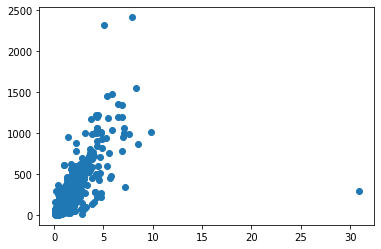

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

tmp = Garosugil[Garosugil.가로수수량.isna()==False]#가로수가 결측치인것을 제외한 데이터프레임
plt.scatter(tmp.가로수길길이, tmp.가로수수량)

In [29]:
#가로수수량이 가로수길길이와 어느정도 선형관계가 보여 단순선형회기식을 결측치를 채워준다.
#이상치 3개만 제거후 진행

In [30]:
tmp[tmp.가로수길길이 > 30].index.tolist()

[2985]

In [31]:
tmp[tmp.가로수수량 > 2000] .index.tolist()

[3264, 4730]

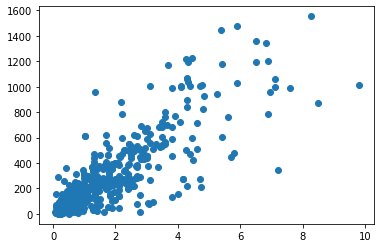

In [32]:
tmp_1 = tmp.iloc[(tmp.index != 2985)&(tmp.index != 3264)&(tmp.index != 4730)]
#이상치를 제거한 데이터프레임

plt.scatter(tmp_1.가로수길길이, tmp_1.가로수수량)

In [33]:
#단순선형회기를 통해 결측치값 채워주기
import numpy as np

x_train = np.array(tmp_1.가로수길길이)
y_train = np.array(tmp_1.가로수수량)

W = 0.0
b = 0.0

n_data = len(x_train)

epochs = 2500
learning_rate = 0.01

for i in range(epochs):
    hypothesis = x_train * W + b
    cost = np.sum((hypothesis - y_train) ** 2) / n_data
    gradient_w = np.sum((W * x_train - y_train + b) * 2 * x_train) / n_data
    gradient_b = np.sum((W * x_train - y_train + b) * 2) / n_data

    W -= learning_rate * gradient_w
    b -= learning_rate * gradient_b

    if i % 100 == 0:
        print('Epoch ({:10d}/{:10d}) cost: {:10f}, W: {:10f}, b:{:10f}'.format(i, epochs, cost, W, b))

print('W: {:10f}'.format(W))
print('b: {:10f}'.format(b))
print('result : ')
print(x_train * W + b)

Epoch (         0/      2500) cost: 120249.127907, W:  12.713972, b:  4.454070
Epoch (       100/      2500) cost: 19643.211769, W: 147.580324, b: 29.643617
Epoch (       200/      2500) cost: 19546.862230, W: 150.948133, b: 20.877479
Epoch (       300/      2500) cost: 19532.945645, W: 152.224527, b: 17.544534
Epoch (       400/      2500) cost: 19530.935543, W: 152.709623, b: 16.277843
Epoch (       500/      2500) cost: 19530.645205, W: 152.893985, b: 15.796435
Epoch (       600/      2500) cost: 19530.603269, W: 152.964051, b: 15.613474
Epoch (       700/      2500) cost: 19530.597212, W: 152.990681, b: 15.543940
Epoch (       800/      2500) cost: 19530.596337, W: 153.000801, b: 15.517514
Epoch (       900/      2500) cost: 19530.596211, W: 153.004647, b: 15.507470
Epoch (      1000/      2500) cost: 19530.596193, W: 153.006109, b: 15.503653
Epoch (      1100/      2500) cost: 19530.596190, W: 153.006665, b: 15.502202
Epoch (      1200/      2500) cost: 19530.596190, W: 153.006876

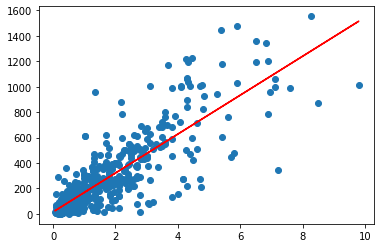

In [34]:
plt.scatter(tmp_1.가로수길길이, tmp_1.가로수수량)
plt.plot(tmp_1.가로수길길이,x_train * W + b,color="red")
# 예측선 시각화

In [35]:
#가중치 W: 153.007005
# 상수 b:  15.501313

In [36]:
Garosugil.가로수수량 = Garosugil.가로수길길이.apply(lambda x : x*153.007005 + 15.501313 if type(x) != int else x)

C:\Users\justi\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [37]:
Garosugil.isna().sum()

가로수길명       0
가로수길시작위도    0
가로수길시작경도    0
가로수길종료위도    0
가로수길종료경도    0
가로수종류       0
가로수수량       0
가로수길길이      0
데이터기준일자     0
제공기관명       0
dtype: int64

#### 가로수수량이0인경우 drop


In [38]:
Garosugil.drop(Garosugil[Garosugil['가로수수량'] == 0].index, inplace = True) #가로수 수량 0인 경우 삭제

C:\Users\justi\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [39]:
0 in Garosugil['가로수수량'].unique()

False

In [40]:
Garosugil.head(5)

,가로수길명,가로수길시작위도,가로수길시작경도,가로수길종료위도,가로수길종료경도,가로수종류,가로수수량,가로수길길이,데이터기준일자,제공기관명
732,시흥대로,37.485637,126.903083,37.491981,126.908463,느티나무,168.508318,1.0,2020-04-30,서울특별시 영등포구
733,디지털로,37.487997,126.898076,37.496673,126.907745,은행나무 등,229.711120,1.4,2020-04-30,서울특별시 영등포구
734,국회대로54길,37.525557,126.908695,37.528583,126.907365,이팝나무,137.906917,0.8,2020-04-30,서울특별시 영등포구
735,영등포로53길,37.518789,126.912125,37.522404,126.908771,이팝나무,92.004815,0.5,2020-04-30,서울특별시 영등포구
736,영신로57길,37.521373,126.891526,37.516498,126.920203,느티나무,61.403414,0.3,2020-04-30,서울특별시 영등포구


## 전국도시공원정보표

In [41]:
PATH = P + '\\전국도시공원정보표\\'
citypark = readcsv_(PATH)

(0) 전국도시공원정보표준데이터.csv


폴더 내 csv / xlsx 파일 개수: 1개
총 데이터프레임 개수: 1개


In [42]:
citypark[0].drop(['소재지도로명주소','관리번호','지정고시일','관리기관명','전화번호','제공기관코드'],\
                 axis=1, inplace=True)
#필요없는 컬럼 드랍 #관리번호, 지정고시일, 관기기관명, 전화번호, 제공기관코드, 도로명주소, 
citypark[0] = citypark[0][citypark[0].제공기관명.str.contains('서울')]
#서울만 골라내기
citypark[0][["공원보유시설(운동시설)","공원보유시설(유희시설)","공원보유시설(편익시설)","공원보유시설(교양시설)","공원보유시설(기타시설)"]]=\
citypark[0][["공원보유시설(운동시설)","공원보유시설(유희시설)","공원보유시설(편익시설)","공원보유시설(교양시설)","공원보유시설(기타시설)"]]\
.fillna(0)#시설 결측치 0으로 대체
#시설 안에 있는 정보는 추후 진행

Citypark = citypark[0]
Citypark.isna().sum()

공원명              0
공원구분             0
소재지지번주소         17
위도              25
경도              26
공원면적             0
공원보유시설(운동시설)     0
공원보유시설(유희시설)     0
공원보유시설(편익시설)     0
공원보유시설(교양시설)     0
공원보유시설(기타시설)     0
데이터기준일자          0
제공기관명            0
dtype: int64

In [84]:
Citypark.head(2)

NameError: name 'Citypark' is not defined

In [44]:
# 주소 Nan인 행
Citypark.loc[4344]

공원명                            백설
공원구분                        어린이공원
소재지지번주소                       NaN
위도                        37.4762
경도                        126.954
공원면적                         1655
공원보유시설(운동시설)                    0
공원보유시설(유희시설)    그네+미끄럼틀+흔들말+조합놀이대
공원보유시설(편익시설)                    0
공원보유시설(교양시설)                    0
공원보유시설(기타시설)                    0
데이터기준일자                2020-06-02
제공기관명                   서울특별시 관악구
Name: 4344, dtype: object

#### 주소 Nan 처리

In [45]:
Citypark.소재지지번주소.fillna('0',inplace=True)

In [46]:
# for i,x in Citypark.iterrows():
#     if x.소재지지번주소=='0':
#         Citypark.loc[i,'소재지지번주소'] = get_addr( x.경도, x.위도)

In [47]:
Citypark['소재지지번주소'] = Citypark.apply(lambda x: get_addr(x['경도'], x['위도']) if x['소재지지번주소'] == '0' else x['소재지지번주소'], axis = 1)

In [48]:
# for i in Citypark[Citypark.소재지지번주소.isna()].index:
#     Citypark.loc[i].소재지지번주소.replace('0', get_addr(Citypark.loc[i].위도, Citypark.loc[i].경도),inplace = True)

In [49]:
Citypark.loc[4344]

공원명                                백설
공원구분                            어린이공원
소재지지번주소         서울특별시 관악구 봉천동 1606-11
위도                            37.4762
경도                            126.954
공원면적                             1655
공원보유시설(운동시설)                        0
공원보유시설(유희시설)        그네+미끄럼틀+흔들말+조합놀이대
공원보유시설(편익시설)                        0
공원보유시설(교양시설)                        0
공원보유시설(기타시설)                        0
데이터기준일자                    2020-06-02
제공기관명                       서울특별시 관악구
Name: 4344, dtype: object

In [50]:
#위도, 경도, 주소 채우기 api로

#### 위경도 Nan 처리

In [51]:
Citypark['위도'].fillna('0', inplace= True)
Citypark['경도'].fillna('0', inplace= True)

In [52]:
Citypark[(Citypark['위도'] =='0') | (Citypark['경도'] =='0')]

,공원명,공원구분,소재지지번주소,위도,경도,공원면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설),데이터기준일자,제공기관명
2090,북한산 도시자연공원,기타,서울특별시 강북구 미아동 산108-19,0,0,128341.0,배드민턴장 게이트볼장 족구장,그네 회전놀이 조합놀이대,화장실,0,유아숲체험원,2020-09-01,서울특별시 강북구
2092,하 늘,어린이공원,서울특별시 강북구 삼양동 791-1776,0,127.013,3367.0,0,조합놀이대 그네 흔들놀이 시소,0,0,0,2020-09-01,서울특별시 강북구
2093,송 월,어린이공원,서울특별시 강북구 송중동 92-7,0,127.032,807.0,0,조합놀이대 시소 그네,0,0,0,2020-09-01,서울특별시 강북구
2094,소망,소공원,서울특별시 강북구 삼양동 791-1467,37.626,0,320.0,0,조합놀이대,0,0,0,2020-09-01,서울특별시 강북구
2096,늘푸른,소공원,서울특별시 강북구 삼양동 797-9,0,127.02,646.0,0,조합놀이대 흔들놀이,0,0,0,2020-09-01,서울특별시 강북구
2141,색 동,어린이공원,서울특별시 강북구 수유1동 49-7,37.6334,0,2341.2,0,조합놀이대 그네 흔들놀이,0,0,0,2020-09-01,서울특별시 강북구
2150,새 싹,어린이공원,서울특별시 강북구 수유3동 134-40,37.6363,0,651.0,0,조합놀이대 시소,0,0,0,2020-09-01,서울특별시 강북구
3758,솔말소공원,근린공원,서울특별시 강동구 암사3동 400-1,37.5565,0,1108.6,체력단련기구,0,0,0,0,2020-09-11,서울특별시 강동구
3760,암사공원,근린공원,서울특별시 강동구 암사3동 414-20,37.5565,0,7047.0,체력단련기구,그네,0,0,0,2020-09-11,서울특별시 강동구
4461,은곡마을공원,어린이공원,서울특별시 강남구 세곡동 369-3,0,127.096,2686.0,0,0,0,0,0,2020-08-27,서울특별시 강남구


In [53]:
Citypark[(Citypark['위도'] =='0') | (Citypark['경도'] =='0')].index

Int64Index([2090, 2092, 2093, 2094, 2096, 2141, 2150, 3758, 3760, 4461, 4462,
            4465, 4466, 4470, 4479, 4481, 4482, 4483, 4484, 4485, 4486, 4489,
            4495, 4506, 4514, 4515, 4517, 4518, 4520, 4522, 4531, 4540, 4541,
            4557, 4561, 4562, 4567, 4573, 4575, 4576, 4577, 4578, 4652],
           dtype='int64')

In [54]:
for i in Citypark.index:
    long = Citypark.loc[i, '경도']
    lat = Citypark.loc[i, '위도']
    if long == '0' or lat =='0':
        try:
#             print(i, 'detected')
#             print(Citypark.loc[i, '소재지지번주소'])
            Citypark.loc[i, '위도'] = get_longlat(Citypark.loc[i, '소재지지번주소'])[1]
            Citypark.loc[i, '경도'] = get_longlat(Citypark.loc[i, '소재지지번주소'])[0]
        except:
            print(f'**Error: index {i}**')
            pass
print('completed')

**Error: index 2093**
**Error: index 2141**
**Error: index 2150**
**Error: index 3758**
**Error: index 3760**
**Error: index 4479**
**Error: index 4652**
completed


In [55]:
### API에서 에러나 나는 공원들 -> 수동 입력 대상

Citypark[(Citypark['위도'] =='0') | (Citypark['경도'] =='0')]

,공원명,공원구분,소재지지번주소,위도,경도,공원면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설),데이터기준일자,제공기관명
2093,송 월,어린이공원,서울특별시 강북구 송중동 92-7,0,127.032,807.0,0,조합놀이대 시소 그네,0,0,0,2020-09-01,서울특별시 강북구
2141,색 동,어린이공원,서울특별시 강북구 수유1동 49-7,37.6334,0,2341.2,0,조합놀이대 그네 흔들놀이,0,0,0,2020-09-01,서울특별시 강북구
2150,새 싹,어린이공원,서울특별시 강북구 수유3동 134-40,37.6363,0,651.0,0,조합놀이대 시소,0,0,0,2020-09-01,서울특별시 강북구
3758,솔말소공원,근린공원,서울특별시 강동구 암사3동 400-1,37.5565,0,1108.6,체력단련기구,0,0,0,0,2020-09-11,서울특별시 강동구
3760,암사공원,근린공원,서울특별시 강동구 암사3동 414-20,37.5565,0,7047.0,체력단련기구,그네,0,0,0,2020-09-11,서울특별시 강동구
4479,대치청실아파트 소공원1,소공원,서울특별시 강남구 대치동 633,37.4943,0,3845.0,0,0,0,0,0,2020-08-27,서울특별시 강남구
4652,단군,어린이공원,서울특별시 금천구 시흥4동 169-21,37.4557,0,250.0,0,조합놀이대,0,0,0,2020-09-02,서울특별시 금천구


get_longlat('서울특별시 강북구 송중동 92-7')

#### 수동으로 채워주기

In [56]:
Citypark[(Citypark['위도'] =='0') | (Citypark['경도'] =='0')].index

Int64Index([2093, 2141, 2150, 3758, 3760, 4479, 4652], dtype='int64')

In [57]:
i = 2093
Citypark.loc[i, '위도'] = 37.61639691683402
Citypark.loc[i, '경도'] = 127.0320928978209

i = 2141
Citypark.loc[i, '위도'] = 37.6333517175513
Citypark.loc[i, '경도'] = 127.02060215574991

i = 2150
Citypark.loc[i, '위도'] = 37.6362569964545
Citypark.loc[i, '경도'] = 127.01953924040653

i = 3758
Citypark.loc[i, '위도'] = 37.556634701906205
Citypark.loc[i, '경도'] = 127.13908718273325

i = 3760
Citypark.loc[i, '위도'] = 37.55507879499802
Citypark.loc[i, '경도'] = 127.14087039807644

i = 4479
Citypark.loc[i, '위도'] = 37.494428814774054
Citypark.loc[i, '경도'] = 127.05836139807522

i = 4652
Citypark.loc[i, '위도'] = 37.455832332626805
Citypark.loc[i, '경도'] = 126.90859535389545

In [58]:
Citypark[(Citypark['위도'] =='0') | (Citypark['경도'] =='0')].index

Int64Index([], dtype='int64')

## 전통시장 표준 데이터

In [59]:
PATH = P + '\\전통시장표준데이터\\'
market = readcsv_(PATH)

(0) 전국전통시장표준데이터.csv
(1) 전통시장현황_20200226..csv


폴더 내 csv / xlsx 파일 개수: 2개
총 데이터프레임 개수: 2개


In [60]:
market[1]

,시장형태,등록형태,시도,시군구,시장명,주소(지번),주소(도로명),"시장크기 (1=대형시장, 2=중대형시장, 3=중형시장, 4=소형시장)","시장면적(단위선택: 1=제곱미터, 2=평형)",시장면적(㎡),...,"보유여부 - 13건물실내조명 (LED조명 설치 여부)(1=LED조명, 2=형광등 및 백열등)","보유여부 - 13건물실내조명 (LED조명 설치 여부)(1=LED조명, 2=형광등 및 백열등).1","보유여부 - 1이동/고정식,이벤트 광장(1=있음, 2=없음)","보유여부 - 2테마거리(1=있음, 2=없음)","보유여부 - 3TV광고판(1=있음, 2=없음)","보유여부 - 4LED광고판(1=있음, 2=없음)","보유여부 - 6아치/조형물(1=있음, 2=없음)","시장/상점가의 주력 상품 여부(1=있음, 2=없음)","시장/상점가의 주력 상품의 개수(1=1개, 2=2개, 3=3개, 4=4개 이상)",시장/상점가의 주력 상품의 상품명
0,전통시장,등록,강원,강릉시,강릉동부시장,강원도 강릉시 옥천동 48,강원도 강릉시 수문길19번옆길 12-1,3,1,"7,109",...,1.0,2.0,2,2,2,2,1,1,1.0,건어물
1,전통시장,등록,강원,강릉시,강릉서부시장,강원도 강릉시 용강동 29,강원도 강릉시 임영로 155번길 6,4,1,"3,707",...,1.0,NaN,2,2,2,2,1,1,3.0,컴퓨터기기 감자전 추어탕
2,전통시장,인정,강원,강릉시,강릉성남시장,강원도 강릉시 성남동 53-8,강원도 강릉시 중앙시장길 24-2,3,1,"7,223",...,1.0,2.0,1,1,1,1,1,1,4.0,닭강정 국수 호떡 어묵고로케
3,전통시장,인정,강원,강릉시,주문진건어물시장,강원도 강릉시 주문리 312-708,강원도 강릉시 주문진읍 해안로1748,3,1,"26,359",...,1.0,2.0,1,1,2,2,2,1,4.0,건어물 수산물 회 대게
4,전통시장,등록,강원,강릉시,주문진수산시장,강원도 강릉시 주문리 312-91,강원도 강릉시주문진읍 시장1길 4 - 1,4,1,"1,881",...,1.0,NaN,1,1,1,1,1,1,4.0,문어 복어 홍개 대게 등
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,전통시장,인정,충북,충주시,중앙어울림시장,충청북도 충주시 성서동 306,충청북도 충주시 예성로 168,4,1,"2,319",...,1.0,NaN,2,2,2,2,1,2,NaN,NaN
1446,전통시장,인정,충북,충주시,충주옹달샘시장,충청북도 충주시 지현동 1431,충청북도 충주시 지곡10길 38- 1,4,1,"1,587",...,1.0,NaN,2,2,2,2,1,2,NaN,NaN
1447,전통시장,인정,충북,충주시,충주자유시장,충청북도 충주시 충의동 192,충청북도 충주시 충인 6길 16,3,1,"10,862",...,1.0,NaN,1,2,2,1,1,2,NaN,NaN
1448,전통시장,등록,충북,충주시,현대타운상가,충청북도 충주시 성서동 163,충청북도 충주시 성서1길 50,4,1,"38,782",...,1.0,NaN,1,2,2,1,2,2,NaN,NaN


In [61]:
market[1] = market[1][market[1].시도 =='서울']

In [62]:
market[1] = market[1][['시장형태','시군구','시장명','주소(지번)','주소(도로명)',\
           '시장크기 (1=대형시장, 2=중대형시장, 3=중형시장, 4=소형시장)','시장면적(㎡)',\
          '외부형태(전통시장: 1=상가건물형, 2=노점형, 3=장옥형, 4=상가주택형)','개설주기(1=상설, 2=정기, 3=상설+정기)',\
          '전체점포수','영업점포수(합)','비영업 점포수(빈점포)','보유현황 - 7자전거보관함(1=있음, 2=없음)',\
          '문2) 보유현황 - 12고객동선통로(1=있음, 2=없음)','보유여부 - 3공동화장실(1=있음, 2=없음)',\
          '보유여부 - 1이동/고정식,이벤트 광장(1=있음, 2=없음)','보유여부 - 2테마거리(1=있음, 2=없음)']]

#살릴목록
시장형태                                                                     0                                                                    0
시도                                                                       0
시군구                                                                      0
시장명                                                                      0
주소(지번)                                                                   0
주소(도로명)                                                                  0
시장크기 (1=대형시장, 2=중대형시장, 3=중형시장, 4=소형시장)
시장면적(m)
외부형태(전통시장: 1=상가건물형, 2=노점형, 3=장옥형, 4=상가주택형)                               0
개설주기(1=상설, 2=정기, 3=상설+정기) 
전체점포수                                                                    0
영업점포수(합)                                                                 0                                                           0
비영업 점포수(빈점포)                                                             0
보유현황 - 7자전거보관함(1=있음, 2=없음)
문2) 보유현황 - 12고객동선통로(1=있음, 2=없음)
보유여부 - 3공동화장실(1=있음, 2=없음)
보유여부 - 1이동/고정식,이벤트 광장(1=있음, 2=없음)
보유여부 - 2테마거리(1=있음, 2=없음)

In [63]:
Market = market[1]

In [64]:
Market.isna().sum()

시장형태                                          0
시군구                                           0
시장명                                           0
주소(지번)                                        0
주소(도로명)                                       0
시장크기 (1=대형시장, 2=중대형시장, 3=중형시장, 4=소형시장)        0
시장면적(㎡)                                       0
외부형태(전통시장: 1=상가건물형, 2=노점형, 3=장옥형, 4=상가주택형)    0
개설주기(1=상설, 2=정기, 3=상설+정기)                     0
전체점포수                                         0
영업점포수(합)                                      0
비영업 점포수(빈점포)                                  0
보유현황 - 7자전거보관함(1=있음, 2=없음)                    0
문2) 보유현황 - 12고객동선통로(1=있음, 2=없음)               0
보유여부 - 3공동화장실(1=있음, 2=없음)                     0
보유여부 - 1이동/고정식,이벤트 광장(1=있음, 2=없음)             0
보유여부 - 2테마거리(1=있음, 2=없음)                      0
dtype: int64

#### 위경도 추가

In [65]:
Market.head(4)

,시장형태,시군구,시장명,주소(지번),주소(도로명),"시장크기 (1=대형시장, 2=중대형시장, 3=중형시장, 4=소형시장)",시장면적(㎡),"외부형태(전통시장: 1=상가건물형, 2=노점형, 3=장옥형, 4=상가주택형)","개설주기(1=상설, 2=정기, 3=상설+정기)",전체점포수,영업점포수(합),비영업 점포수(빈점포),"보유현황 - 7자전거보관함(1=있음, 2=없음)","문2) 보유현황 - 12고객동선통로(1=있음, 2=없음)","보유여부 - 3공동화장실(1=있음, 2=없음)","보유여부 - 1이동/고정식,이벤트 광장(1=있음, 2=없음)","보유여부 - 2테마거리(1=있음, 2=없음)"
848,전통시장,강남구,강남시장,서울특별시 강남구 신사동 510-11,서울특별시 강남구 압구정로 2길 46,4,"3,690",1,1,70,70,0,2,2,1,2,2
849,전통시장,강남구,논현종합시장,서울특별시 강남구 논현동 277의 4,서울특별시 강남구 봉은사로43길 8,4,"1,000",4,1,44,14,30,2,2,1,2,2
850,전통시장,강남구,신사상가,서울특별시 강남구 압구정동 454,서울특별시 강남구 압구정로29길 72-1,4,"2,119",1,1,98,88,10,2,1,1,2,2
851,전통시장,강남구,영동전통시장,서울특별시 강남구 논현동 140,서울특별시 강남구 강남대로 128길 20 영동프라자 2동 204호,3,"13,099",4,1,115,115,0,2,1,1,2,2


In [66]:
Market['위도'] = 0
Market['경도'] = 0

In [67]:
#전통시장 정보를 어떤 것을 사용할지 고민해봐야한다. -> market[0]으로 사용,  
#위도 경도를 api로 추가해줘야함

In [68]:
for i in notebook.tqdm(Market.index):
    try:
        print(i, Market.loc[i, '주소(지번)'])
        Market.loc[i, '위도'] = get_longlat(Market.loc[i, '주소(지번)'])[0]
        Market.loc[i, '경도'] = get_longlat(Market.loc[i, '주소(지번)'])[1]
    except:
        try:
            print(i, Market.loc[i, '주소(도로명)'])
            Market.loc[i, '위도'] = get_longlat(Market.loc[i, '주소(도로명)'])[0]
            Market.loc[i, '경도'] = get_longlat(Market.loc[i, '주소(도로명)'])[1]
        except:
            print(f'**Error: index {i}**')
            pass
print('completed')

848 서울특별시 강남구 신사동 510-11
849 서울특별시 강남구 논현동 277의 4
850 서울특별시 강남구 압구정동 454
851 서울특별시 강남구 논현동 140
852 서울특별시 강남구 청담동 134-20
853 서울특별시 강동구 고덕동 210-5
854 서울특별시 강동구 천호동 393-32
855 서울특별시 강동구 천호대로193길 37
856 서울특별시 강동구 천호2동 422의1
856 서울특별시 강동구 올림픽로80길 58
857 서울특별시 강동구 성내동 416-12
858 서울특별시 강동구 명일동 333-2 일대
859 서울특별시 강동구 성내동 144-12
860 서울특별시 강동구 암사동 501-18
861 서울특별시 강동구 천호동 421-1
862 서울특별시 강동구 천호동 422-2
863 서울특별시 강북구  번동 413-3
864 서울특별시 강북구 수유동 177-7호
864 서울특별시 강북구 한천로144길 12
865 서울특별시 강북구 미아동 701-3
866 서울특별시 강북구 수유동 413-2
867 서울특별시 강북구 수유1동 54-5
867 서울특별시 강북구 도봉로67길 18 
868 서울특별시 강북구 수유1동 50-77
868 서울특별시 강북구 도봉로71길 26
869 서울특별시 강북구 수유동 54-5
870 서울특별시 강북로 수유동 32-2
870 서울특별시 강북로 노해로 17길 21
**Error: index 870**
871 서울특별시 강북구 수유동 63
872 서울특별시 강북구 미아동 60-5
873 서울특별시 강북구 수유동 270-185
874 서울특별시 강북구 수유동 316-11
875 서울특별시 강서구  화곡동 342-16
876 서울특별시 강서구 화곡동 797-7
877 서울특별시 강서구 화곡동 830-1
878 서울특별시 강서구 화곡3동 1023
878 서울특별시 강서구 화곡로21길 78
879 서울특별시 강서구 등촌동 637의10
880 서울특별시 강서구 방화동 579-1
881 서울특별시 강서구 화곡동 929-1
882

In [69]:
# Market['위도'] = Market['주소(도로명)'].apply(lambda x: get_longlat(x)[0])

In [70]:
# Market['위도'].apply(lambda x: get_longlat(Market['주소(도로명)'])[0])

In [71]:
Market.head()

,시장형태,시군구,시장명,주소(지번),주소(도로명),"시장크기 (1=대형시장, 2=중대형시장, 3=중형시장, 4=소형시장)",시장면적(㎡),"외부형태(전통시장: 1=상가건물형, 2=노점형, 3=장옥형, 4=상가주택형)","개설주기(1=상설, 2=정기, 3=상설+정기)",전체점포수,영업점포수(합),비영업 점포수(빈점포),"보유현황 - 7자전거보관함(1=있음, 2=없음)","문2) 보유현황 - 12고객동선통로(1=있음, 2=없음)","보유여부 - 3공동화장실(1=있음, 2=없음)","보유여부 - 1이동/고정식,이벤트 광장(1=있음, 2=없음)","보유여부 - 2테마거리(1=있음, 2=없음)",위도,경도
848,전통시장,강남구,강남시장,서울특별시 강남구 신사동 510-11,서울특별시 강남구 압구정로 2길 46,4,"3,690",1,1,70,70,0,2,2,1,2,2,127.020667273872,37.5187696435619
849,전통시장,강남구,논현종합시장,서울특별시 강남구 논현동 277의 4,서울특별시 강남구 봉은사로43길 8,4,"1,000",4,1,44,14,30,2,2,1,2,2,127.039972286486,37.5098028578174
850,전통시장,강남구,신사상가,서울특별시 강남구 압구정동 454,서울특별시 강남구 압구정로29길 72-1,4,"2,119",1,1,98,88,10,2,1,1,2,2,127.028381249734,37.5322823346864
851,전통시장,강남구,영동전통시장,서울특별시 강남구 논현동 140,서울특별시 강남구 강남대로 128길 20 영동프라자 2동 204호,3,"13,099",4,1,115,115,0,2,1,1,2,2,127.026314841,37.512373135
852,전통시장,강남구,청담삼익시장,서울특별시 강남구 청담동 134-20,서울특별시 강남구 학동로 101길 26,4,"2,479",1,1,120,80,10,2,1,1,2,2,127.057724400967,37.5222984058618


#### 예외처리 된 row

In [72]:
Market[(Market['위도'] == 0) | (Market['위도'] == 0)]

,시장형태,시군구,시장명,주소(지번),주소(도로명),"시장크기 (1=대형시장, 2=중대형시장, 3=중형시장, 4=소형시장)",시장면적(㎡),"외부형태(전통시장: 1=상가건물형, 2=노점형, 3=장옥형, 4=상가주택형)","개설주기(1=상설, 2=정기, 3=상설+정기)",전체점포수,영업점포수(합),비영업 점포수(빈점포),"보유현황 - 7자전거보관함(1=있음, 2=없음)","문2) 보유현황 - 12고객동선통로(1=있음, 2=없음)","보유여부 - 3공동화장실(1=있음, 2=없음)","보유여부 - 1이동/고정식,이벤트 광장(1=있음, 2=없음)","보유여부 - 2테마거리(1=있음, 2=없음)",위도,경도
870,전통시장,강북구,수유중앙시장,서울특별시 강북로 수유동 32-2,서울특별시 강북로 노해로 17길 21,4,"3,319",1,1,37,34,3,2,2,1,2,2,0,0
902,전통시장,광진구,영동교골목시장,서울특별시 광진구 자양4동 246의111,서울특별시 광진구 동일로10길 30,3,"8,481",4,1,105,100,5,2,1,1,2,2,0,0
909,전통시장,구로구,개봉프라자,서울특별시 구로구 개봉동 269의1,서울특별시 구로구 개봉로11나길 10-16,4,"2,653",1,1,114,61,53,1,1,1,2,2,0,0
964,전통시장,서대문구,유진상가,서울특별시 서대문구 홍은동 48-84,서울특별시 서대문구 홍은동 통일로 484,4,"9,504",1,1,80,80,0,2,2,1,1,2,0,0


In [73]:
Market[(Market['위도'] == 0) | (Market['위도'] == 0)].index

Int64Index([870, 902, 909, 964], dtype='int64')

#### 수동으로 채워주기

In [74]:
i = 870
Market.loc[i, '위도'] = 37.64048729007286
Market.loc[i, '경도'] = 127.02138231342151

i = 902
Market.loc[i, '위도'] = 37.53818266519323
Market.loc[i, '경도'] = 127.06326475389696

i = 909
Market.loc[i, '위도'] = 37.489750564422444
Market.loc[i, '경도'] = 126.8515960385527

i = 964
Market.loc[i, '위도'] = 37.59129950814002
Market.loc[i, '경도'] = 126.94211539807718	

In [75]:
Market[(Market['위도'] == 0) | (Market['위도'] == 0)]

,시장형태,시군구,시장명,주소(지번),주소(도로명),"시장크기 (1=대형시장, 2=중대형시장, 3=중형시장, 4=소형시장)",시장면적(㎡),"외부형태(전통시장: 1=상가건물형, 2=노점형, 3=장옥형, 4=상가주택형)","개설주기(1=상설, 2=정기, 3=상설+정기)",전체점포수,영업점포수(합),비영업 점포수(빈점포),"보유현황 - 7자전거보관함(1=있음, 2=없음)","문2) 보유현황 - 12고객동선통로(1=있음, 2=없음)","보유여부 - 3공동화장실(1=있음, 2=없음)","보유여부 - 1이동/고정식,이벤트 광장(1=있음, 2=없음)","보유여부 - 2테마거리(1=있음, 2=없음)",위도,경도


## 지하철 정보

In [16]:
PATH = P + '\\지하철정보\\'
subway = readcsv_(PATH)

(0) all_subway0.csv
(1) 서울특별시 노선별 지하철역 정보(신규).csv


폴더 내 csv / xlsx 파일 개수: 2개
총 데이터프레임 개수: 2개


In [17]:
Subway = subway[0]
Subway.head(5)

,지번주소,역명,선명
0,서울특별시 도봉구 도봉동 18-1,도봉산 1호선,1호선
1,서울특별시 도봉구 도봉동 639,도봉 1호선,1호선
2,서울특별시 도봉구 방학동 728,방학 1호선,1호선
3,서울특별시 도봉구 창동 135-1,창동 1호선,1호선
4,서울특별시 도봉구 창동 57-11,녹천 1호선,1호선


#### 위경도 추가

In [18]:
Subway['위도'] = 0
Subway['경도'] = 0

for i in notebook.tqdm(Subway.index):
    try:
        print(i, Subway.loc[i, '지번주소'])
        Subway.loc[i, '위도'] = get_longlat(Subway.loc[i, '지번주소'])[1]
        Subway.loc[i, '경도'] = get_longlat(Subway.loc[i, '지번주소'])[0]
    except:
        print(f'**Error: index {i}**')
        pass
print('completed')

0 서울특별시 도봉구 도봉동 18-1
1 서울특별시 도봉구 도봉동 639
2 서울특별시 도봉구 방학동 728
3 서울특별시 도봉구 창동 135-1
4 서울특별시 도봉구 창동 57-11
5 서울특별시 노원구 월계동 263-1
6 서울특별시 노원구 월계동 85
7 서울특별시 노원구 월계동 36-4
8 서울특별시 동대문구 이문동 7
9 서울특별시 동대문구 이문동 360-5
10 서울특별시 동대문구 휘경동 317-101
11 서울특별시 용산구 갈월동 96-1
12 서울특별시 용산구 한강로3가 40-999
13 서울특별시 동작구 노량진동 67-2
14 서울특별시 영등포구 신길동 1368-3
15 서울특별시 영등포구 신길동 41-1
16 서울특별시 영등포구 영등포동 618-496
17 서울특별시 구로구 신도림동 460-26
18 서울특별시 구로구 구로동 585-3
19 서울특별시 구로구 구로동 636-45
20 서울특별시 구로구 개봉동 415
21 서울특별시 구로구 오류동 66
22 서울특별시 금천구 가산동 468-4
23 서울특별시 금천구 가산동 717
24 서울특별시 금천구 시흥동 113-55
25 서울특별시 동대문구 왕산로 328-1
**Error: index 25**
26 서울특별시 동대문구 제기동 65
27 서울특별시 동대문구 신설동 76-5
28 서울특별시 종로구 숭인동 117
29 서울특별시 종로구 창신동 492-1
30 서울특별시 종로구 종로5가 82-1
31 서울특별시 종로구 종로3가 10-5
32 서울특별시 종로구 종로1가 54
33 서울특별시 중구 정동 5-5
34 서울특별시 중구 남대문로5가 73-6
35 서울특별시 중구 서소문동 90-1
36 서울특별시 중구 을지로3가 347-3
37 서울특별시 중구 을지로4가 267-1
38 서울특별시 중구 을지로7가 112-3
39 서울특별시 중구 신당동 99
40 서울특별시 성동구 하왕십리동 946-14
41 서울특별시 성동구 행당동 192
**Error: index 41**
42 서울특별시 성동구 행당동 산

329 서울특별시 중랑구 신내동 643-1

completed


In [19]:
Subway

,지번주소,역명,선명,위도,경도
0,서울특별시 도봉구 도봉동 18-1,도봉산 1호선,1호선,37.680041668,127.039988377
1,서울특별시 도봉구 도봉동 639,도봉 1호선,1호선,37.6750864511203,127.044867211119
2,서울특별시 도봉구 방학동 728,방학 1호선,1호선,37.669294068,127.043857656
3,서울특별시 도봉구 창동 135-1,창동 1호선,1호선,37.6534847604984,127.04759286259
4,서울특별시 도봉구 창동 57-11,녹천 1호선,1호선,37.639372574,127.036704639
...,...,...,...,...,...
325,서울특별시 성북구 석관동 349-8,돌곶이 6호선,6호선,37.6105624326389,127.057293279836
326,서울특별시 노원구 월계동 25-2,석계 6호선,6호선,37.617088027,127.06031823
327,서울특별시 노원구 공릉동 616-4,태릉입구 6호선,6호선,37.6191432243296,127.075135984768
328,서울특별시 노원구 공릉동 285-2,화랑대(서울여대입구) 6호선,6호선,37.6198935993706,127.083269921816


#### 예외처리 확인 
- 너무 많다, 다른 API 찾아봐야할 듯

In [20]:
Subway[(Subway['위도'] == 0) | (Subway['위도'] == 0)]

,지번주소,역명,선명,위도,경도
25,서울특별시 동대문구 왕산로 328-1,청량리(서울시립대입구) 1호선,1호선,0,0
41,서울특별시 성동구 행당동 192,왕십리 2호선,2호선,0,0
42,서울특별시 성동구 행당동 산17,한양대 2호선,2호선,0,0
43,서울특별시 성동구 성수동1가 656-745,뚝섬 2호선,2호선,0,0
71,서울특별시 마포구 서교동 393,합정 2호선,2호선,0,0
85,서울특별시 종로구 안국동 155-2,안국 3호선,3호선,0,0
91,서울특별시 성동구 금호동4가 1470,금호 3호선,3호선,0,0
118,서울특별시 성북구 길음동 877-66,길음 4호선,4호선,0,0
140,서울특별시 강서구 가양동 530-6,마곡 5호선,5호선,0,0
156,서울특별시 마포구 아현동 612,애오개 5호선,5호선,0,0


25	서울특별시 동대문구 왕산로 328-1 -> 없는 주소

In [22]:
i = 25
Subway.loc[i, '위도'] = 37.580130642105125
Subway.loc[i, '경도'] = 127.04759340574972

i = 41
Subway.loc[i, '위도'] = 37.562411663447904
Subway.loc[i, '경도'] = 127.03712030971857

i = 42
Subway.loc[i, '위도'] = 37.55544639957104
Subway.loc[i, '경도'] = 127.0437329999274

i = 43
Subway.loc[i, '위도'] = 37.5473474071512
Subway.loc[i, '경도'] =127.04740165574817

i = 71
Subway.loc[i, '위도'] = 37.550266319809495
Subway.loc[i, '경도'] = 126.9144964594476

i = 85
Subway.loc[i, '위도'] = 37.57693406362475
Subway.loc[i, '경도'] = 126.9858572422561

i = 91
Subway.loc[i, '위도'] = 37.54817418014116
Subway.loc[i, '경도'] = 127.01581822506144

i = 118
Subway.loc[i, '위도'] = 37.60338687918267
Subway.loc[i, '경도'] = 127.0249217827342

i = 140
Subway.loc[i, '위도'] = 37.5604187626603
Subway.loc[i, '경도'] = 126.82498051156912

i = 156
Subway.loc[i, '위도'] = 37.55344637350772
Subway.loc[i, '경도'] = 126.95671586807437

i = 165
Subway.loc[i, '위도'] = 37.557505604840884
Subway.loc[i, '경도'] = 127.02943261156915

i = 166
Subway.loc[i, '위도'] = 37.56197792563526
Subway.loc[i, '경도'] = 127.03735634410667

i = 167
Subway.loc[i, '위도'] = 37.5663088763615
Subway.loc[i, '경도'] = 127.04287885937546

i = 175
Subway.loc[i, '위도'] = 37.53856174196327
Subway.loc[i, '경도'] = 127.14023678458358

i = 177
Subway.loc[i, '위도'] = 37.55146998592976
Subway.loc[i, '경도'] = 127.14396331156897

i = 180
Subway.loc[i, '위도'] = 37.527954242817216
Subway.loc[i, '경도'] = 127.13625702691172	

i = 201
Subway.loc[i, '위도'] = 37.565850747856274
Subway.loc[i, '경도'] = 127.08424534225585

i = 224
Subway.loc[i, '위도'] = 37.486664282535486
Subway.loc[i, '경도'] = 126.83870352995962

i = 228
Subway.loc[i, '위도'] = 37.530530053433644, 
Subway.loc[i, '경도'] = 127.1205293120709

i = 301
Subway.loc[i, '위도'] = 37.56940981156322
Subway.loc[i, '경도'] = 126.89908466491741

i = 302
Subway.loc[i, '위도'] = 37.5651833157907
Subway.loc[i, '경도'] = 126.90143913805923

i = 303
Subway.loc[i, '위도'] = 37.5559698144456
Subway.loc[i, '경도'] = 126.90992845574824

i = 304
Subway.loc[i, '위도'] = 37.549229270699335, 
Subway.loc[i, '경도'] = 126.91346596924063

In [23]:
Subway[(Subway['위도'] == 0) | (Subway['위도'] == 0)]

,지번주소,역명,선명,위도,경도


In [24]:
Subway['경도']

,지번주소,역명,선명,위도,경도
0,서울특별시 도봉구 도봉동 18-1,도봉산 1호선,1호선,37.680041668,127.039988377
1,서울특별시 도봉구 도봉동 639,도봉 1호선,1호선,37.6750864511203,127.044867211119
2,서울특별시 도봉구 방학동 728,방학 1호선,1호선,37.669294068,127.043857656
3,서울특별시 도봉구 창동 135-1,창동 1호선,1호선,37.6534847604984,127.04759286259
4,서울특별시 도봉구 창동 57-11,녹천 1호선,1호선,37.639372574,127.036704639
...,...,...,...,...,...
325,서울특별시 성북구 석관동 349-8,돌곶이 6호선,6호선,37.6105624326389,127.057293279836
326,서울특별시 노원구 월계동 25-2,석계 6호선,6호선,37.617088027,127.06031823
327,서울특별시 노원구 공릉동 616-4,태릉입구 6호선,6호선,37.6191432243296,127.075135984768
328,서울특별시 노원구 공릉동 285-2,화랑대(서울여대입구) 6호선,6호선,37.6198935993706,127.083269921816


## 서울시 인구정보 2019

In [83]:
PATH = P + '\\서울인구2019\\'
cencus2019 = readcsv_(PATH)

(0) 서울인구 2019.csv


폴더 내 csv / xlsx 파일 개수: 1개
총 데이터프레임 개수: 1개


In [84]:
cencus2019[0] = cencus2019[0][['자치구','세대','인구 합계','세대당인구','65세이상고령자']]
#자치구, 세대, 인구합계, 세대당인구, 65세이상 고령자 살리기

cencus2019[0] = cencus2019[0].iloc[1:,:] #전체로우 삭제

In [85]:
Cencus2019 = cencus2019[0]
Cencus2019.head()

,자치구,세대,인구 합계,세대당인구,65세이상고령자
1,종로구,"73,947","161,869",2.05,"27,519"
2,중구,"62,739","136,488",2.01,"23,275"
3,용산구,"110,126","245,185",2.08,"38,791"
4,성동구,"135,838","308,979",2.22,"43,947"
5,광진구,"164,428","366,972",2.14,"47,902"


####  멀티폴리곤 찾아보기

In [86]:
### 금요일 예정이었으나 못함 ㅠㅠ

## 신귝입자
- 필요 없는 데이터

In [87]:
# PATH =  P + '\\신규가입자(월별)\\'
# newbie_list = readcsv_(PATH)

In [88]:
# newbie_list[0]

## SKT 유동인구

In [1]:
PATH = P + '\\skt서울시유동인구\\'
floating_list = readcsv_(PATH)

NameError: name 'P' is not defined

In [90]:
Floating_list = pd.concat([floating_list[0],floating_list[1],floating_list[2],floating_list[3],floating_list[4],floating_list[5],\
           floating_list[6],floating_list[7],floating_list[8],floating_list[9],floating_list[10],floating_list[11],\
           floating_list[12],floating_list[13],floating_list[14],floating_list[15],floating_list[16],\
           floating_list[17]],axis=0)
#성별만 빼기

In [91]:
Floating_list.head(5)

,일자,시간(1시간단위),연령대(10세단위),성별,시,군구,유동인구수
0,20190301,0,20,남성,서울,양천구,28720
1,20190301,0,20,남성,서울,종로구,15920
2,20190301,0,20,남성,서울,중랑구,26250
3,20190301,0,20,여성,서울,중랑구,25890
4,20190301,0,30,남성,서울,강동구,34090


In [92]:
Floating_list.drop('시', axis=1, inplace = True)
Floating_list.일자 = Floating_list.일자.astype("str")
Floating_list.일자 = Floating_list.일자.apply(lambda x :str(x[:4])+'-'+str(x[4:6])+'-'+str(x[6:8]))

In [93]:
Floating_list.일자.unique()[:5]

array(['2019-03-01', '2019-03-02', '2019-03-03', '2019-03-04',
       '2019-03-05'], dtype=object)

In [94]:
Floating_list.drop('성별', axis=1, inplace = True)

In [95]:
Floating_list

,일자,시간(1시간단위),연령대(10세단위),군구,유동인구수
0,2019-03-01,0,20,양천구,28720
1,2019-03-01,0,20,종로구,15920
2,2019-03-01,0,20,중랑구,26250
3,2019-03-01,0,20,중랑구,25890
4,2019-03-01,0,30,강동구,34090
...,...,...,...,...,...
215695,2020-09-30,19,50,도봉구,28610
215696,2020-09-30,20,50,서초구,29580
215697,2020-09-30,20,70,광진구,13670
215698,2020-09-30,21,70,중랑구,13590


## 고장신고내역

In [96]:
PATH = P + '\\고장신고내역\\'
bike_break= readcsv_(PATH)

(0) 서울시 공공자전거 고장신고 내역_2019.12.01_2020.05.31.csv
(1) 서울시 공공자전거 고장신고 내역_2020.06.01_2020.06.30.csv


폴더 내 csv / xlsx 파일 개수: 2개
총 데이터프레임 개수: 2개


In [97]:
bike_break[0].head(5)

,자전거번호,정비날짜,세부내역
0,SPB-15640,2019-12-01 0:10,배터리
1,SPB-21305,2019-12-01 0:13,"배터리,변속기,브레이크,체인"
2,SPB-15833,2019-12-01 0:24,"브레이크,타이어.튜브,체인"
3,SPB-24746,2019-12-01 2:03,"물받이,브레이크,타이어.튜브,체인"
4,SPB-14257,2019-12-01 2:03,"스탠드,물받이,스템,핸들,브레이크,체인"


In [98]:
bike_break[1].head(5)

,자전거번호,정비날짜,세부내역
0,SPB-33031,2020-06-01 1:02,시스템 케이블
1,SPB-07266,2020-06-01 1:11,대여장치 덮개
2,SPB-34365,2020-06-01 1:42,잠금장치 덮개
3,SPB-30233,2020-06-01 1:45,시스템 케이블
4,SPB-23066,2020-06-01 2:08,잠금장치 덮개


In [99]:
Bike_break = pd.concat([bike_break[0],bike_break[1]], axis=0)
#합치기

In [100]:
Bike_break.head()

,자전거번호,정비날짜,세부내역
0,SPB-15640,2019-12-01 0:10,배터리
1,SPB-21305,2019-12-01 0:13,"배터리,변속기,브레이크,체인"
2,SPB-15833,2019-12-01 0:24,"브레이크,타이어.튜브,체인"
3,SPB-24746,2019-12-01 2:03,"물받이,브레이크,타이어.튜브,체인"
4,SPB-14257,2019-12-01 2:03,"스탠드,물받이,스템,핸들,브레이크,체인"


In [101]:
Bike_break.정비날짜 = Bike_break.정비날짜.apply(lambda x : x.replace('.', '-'))
Bike_break.정비날짜 = Bike_break.정비날짜.apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d %H:%M'))
Bike_break.정비날짜 = Bike_break.정비날짜.apply(lambda x : x.strftime('%Y-%m-%d %H:%M'))
#시간 수정
bike_break[0].정비날짜 = bike_break[0].정비날짜.apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d %H:%M'))
bike_break[0].정비날짜 = bike_break[0].정비날짜.apply(lambda x : x.strftime('%Y-%m-%d %H:%M'))

In [102]:
Bike_break.head()

,자전거번호,정비날짜,세부내역
0,SPB-15640,2019-12-01 00:10,배터리
1,SPB-21305,2019-12-01 00:13,"배터리,변속기,브레이크,체인"
2,SPB-15833,2019-12-01 00:24,"브레이크,타이어.튜브,체인"
3,SPB-24746,2019-12-01 02:03,"물받이,브레이크,타이어.튜브,체인"
4,SPB-14257,2019-12-01 02:03,"스탠드,물받이,스템,핸들,브레이크,체인"


In [103]:
Bike_break['시간'] = Bike_break['정비날짜'].apply(lambda x: x.split(' ')[1])
Bike_break['날짜'] = Bike_break['정비날짜'].apply(lambda x: x.split(' ')[0])

In [104]:
Bike_break.drop('정비날짜', axis = 1, inplace = True)
Bike_break.head()

,자전거번호,세부내역,시간,날짜
0,SPB-15640,배터리,00:10,2019-12-01
1,SPB-21305,"배터리,변속기,브레이크,체인",00:13,2019-12-01
2,SPB-15833,"브레이크,타이어.튜브,체인",00:24,2019-12-01
3,SPB-24746,"물받이,브레이크,타이어.튜브,체인",02:03,2019-12-01
4,SPB-14257,"스탠드,물받이,스템,핸들,브레이크,체인",02:03,2019-12-01


## 공공자전거 이용정보 (월별)

In [12]:
PATH =  P + '\\공공자전거_이용정보(월별)\\'
monthly_bike_usage = readcsv_(PATH)

(0) 공공자전거 이용정보(월별)_19.12.csv
(1) 공공자전거 이용정보(월별)_20.01_20.05.csv
(2) 공공자전거 이용정보(월별)_20.06.csv
(3) 서울특별시 공공자전거 이용정보(월별)_201901_201906.csv
(4) 서울특별시 공공자전거 이용정보(월별)_201907_201911.csv


폴더 내 csv / xlsx 파일 개수: 5개
총 데이터프레임 개수: 5개


#### columns 이름 변경
- 이동거리(M)       
- 이용시간(분) 

In [106]:
monthly_bike_usage[0].head()

,대여일자,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,이용시간
0,Dec-19,3,중랑센터,일일(회원),M,AGE_003,7,1208.87,10.11,43610,118
1,Dec-19,3,중랑센터,일일(회원),M,AGE_004,2,0,0,0,10
2,Dec-19,3,중랑센터,정기,M,AGE_005,5,110.02,1.03,4410,99
3,Dec-19,5,상암센터 정비실,일일(회원),\N,AGE_005,1,0,0,0,8
4,Dec-19,5,상암센터 정비실,일일(회원),M,AGE_004,5,427.8,3.92,16880,205


In [107]:
monthly_bike_usage[1].head()

,대여일자,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,이용시간
0,Jan-20,3,중랑센터,일일(회원),M,AGE_003,3,61.82,0.52,2230.0,75
1,Jan-20,3,중랑센터,일일(회원),M,AGE_004,1,39.62,0.28,1220.0,15
2,Jan-20,3,중랑센터,정기,M,AGE_005,3,430.85,4.01,17270.0,53
3,Jan-20,5,상암센터 정비실,일일(회원),\N,AGE_005,2,1.79,0.02,90.0,33
4,Jan-20,5,상암센터 정비실,정기,F,AGE_003,1,4501.96,45.47,196010.0,64


In [108]:
monthly_bike_usage[2].head()

,대여일자,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리(M),이용시간(분)
0,2020-06,5,상암센터 정비실,일일(회원),\N,AGE_005,5,28.51,0.33,1440.0,141
1,2020-06,5,상암센터 정비실,일일(회원),M,AGE_003,1,\N,\N,0.0,4
2,2020-06,5,상암센터 정비실,일일(회원),M,AGE_004,17,2908.72,26.63,114770.0,278
3,2020-06,5,상암센터 정비실,일일(회원),M,AGE_005,4,0.00,0.00,0.0,80
4,2020-06,5,상암센터 정비실,정기,\N,AGE_008,2,0.00,0.00,0.0,1


In [109]:
monthly_bike_usage[3].head()

,대여일자,대여소번호,대여소,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리(M),이동시간(분)
0,2019-01,3,중랑센터,일일(회원),M,AGE_003,12,288.87,2.25,9690,117
1,2019-01,3,중랑센터,일일(회원),M,AGE_004,8,424.63,3.32,14310,151
2,2019-01,3,중랑센터,일일(회원),M,AGE_005,27,4579.48,41.29,177910,542
3,2019-01,3,중랑센터,정기,M,AGE_003,17,3438.8,33.58,144730,593
4,2019-01,5,상암센터 정비실,일일(회원),M,AGE_004,1,78.31,0.72,3090,33


In [110]:
monthly_bike_usage[4].head()

,대여일자,대여소번호,대여소,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리(M),이동시간(분)
0,2019-07,3,중랑센터,일일(회원),M,AGE_003,6,199.86,1.68,7210,87
1,2019-07,3,중랑센터,일일(회원),M,AGE_004,1,0,0,0,2
2,2019-07,3,중랑센터,일일(회원),M,AGE_005,22,14419.28,129.96,560190,1329
3,2019-07,3,중랑센터,정기,M,AGE_005,13,308.65,2.86,12370,155
4,2019-07,5,상암센터 정비실,일일(회원),M,AGE_005,1,34.47,0.3,1280,6


In [13]:
for i in range(0,5):
    monthly_bike_usage[i].rename(columns = {'이동거리' : '이동거리(M)',
                                            '이용시간' : '이용시간(분)',
                                            '이동시간(분)': '이용시간(분)',
                                            '대여소':'대여소명'
                                           }, inplace = True)
    monthly_bike_usage[i].drop('성별', axis = 1, inplace = True)

In [14]:
monthly_bike_usage[0]['대여일자'] = '2019-12'

In [15]:
monthly_bike_usage[1]

,대여일자,대여소번호,대여소명,대여구분코드,연령대코드,이용건수,운동량,탄소량,이동거리(M),이용시간(분)
0,Jan-20,3,중랑센터,일일(회원),AGE_003,3,61.82,0.52,2230.0,75
1,Jan-20,3,중랑센터,일일(회원),AGE_004,1,39.62,0.28,1220.0,15
2,Jan-20,3,중랑센터,정기,AGE_005,3,430.85,4.01,17270.0,53
3,Jan-20,5,상암센터 정비실,일일(회원),AGE_005,2,1.79,0.02,90.0,33
4,Jan-20,5,상암센터 정비실,정기,AGE_003,1,4501.96,45.47,196010.0,64
...,...,...,...,...,...,...,...,...,...,...
327226,May-20,9997,9997.강남센터,일일(회원),AGE_006,7,689.57,6.22,26790.0,206
327227,May-20,9997,9997.강남센터,정기,AGE_002,1,0,0,0.0,25
327228,May-20,9997,9997.강남센터,정기,AGE_004,2,19.96,0.16,700.0,10
327229,May-20,9997,9997.강남센터,정기,AGE_003,6,43.77,0.34,1470.0,134


In [16]:
monthly_bike_usage[1]['대여일자'] =  monthly_bike_usage[1]['대여일자'].apply(lambda x : x.replace('Jan-20', '2020-01'))
monthly_bike_usage[1]['대여일자'] =  monthly_bike_usage[1]['대여일자'].apply(lambda x : x.replace('Feb-20', '2020-02'))
monthly_bike_usage[1]['대여일자'] =  monthly_bike_usage[1]['대여일자'].apply(lambda x : x.replace('Mar-20', '2020-03'))
monthly_bike_usage[1]['대여일자'] =  monthly_bike_usage[1]['대여일자'].apply(lambda x : x.replace('Apr-20', '2020-04'))
monthly_bike_usage[1]['대여일자'] =  monthly_bike_usage[1]['대여일자'].apply(lambda x : x.replace('May-20', '2020-05'))

In [17]:
monthly_bike_usage[1]

,대여일자,대여소번호,대여소명,대여구분코드,연령대코드,이용건수,운동량,탄소량,이동거리(M),이용시간(분)
0,2020-01,3,중랑센터,일일(회원),AGE_003,3,61.82,0.52,2230.0,75
1,2020-01,3,중랑센터,일일(회원),AGE_004,1,39.62,0.28,1220.0,15
2,2020-01,3,중랑센터,정기,AGE_005,3,430.85,4.01,17270.0,53
3,2020-01,5,상암센터 정비실,일일(회원),AGE_005,2,1.79,0.02,90.0,33
4,2020-01,5,상암센터 정비실,정기,AGE_003,1,4501.96,45.47,196010.0,64
...,...,...,...,...,...,...,...,...,...,...
327226,2020-05,9997,9997.강남센터,일일(회원),AGE_006,7,689.57,6.22,26790.0,206
327227,2020-05,9997,9997.강남센터,정기,AGE_002,1,0,0,0.0,25
327228,2020-05,9997,9997.강남센터,정기,AGE_004,2,19.96,0.16,700.0,10
327229,2020-05,9997,9997.강남센터,정기,AGE_003,6,43.77,0.34,1470.0,134


#### concat하기

In [18]:
Monthly_bike_usage = pd.concat([monthly_bike_usage[0],monthly_bike_usage[1],monthly_bike_usage[2],monthly_bike_usage[3],monthly_bike_usage[3]], axis=0)

In [19]:
Monthly_bike_usage.sort_values(by = '대여일자', inplace= True)

In [20]:
Monthly_bike_usage.isna().sum()

대여일자       0
대여소번호      0
대여소명       0
대여구분코드     0
연령대코드      0
이용건수       0
운동량        0
탄소량        0
이동거리(M)    0
이용시간(분)    0
dtype: int64

In [21]:
Monthly_bike_usage

,대여일자,대여소번호,대여소명,대여구분코드,연령대코드,이용건수,운동량,탄소량,이동거리(M),이용시간(분)
0,2019-01,3,중랑센터,일일(회원),AGE_003,12,288.87,2.25,9690.0,117
709,2019-01,128,128. 신촌역(2호선) 1번출구 옆,일일(회원),AGE_003,12,1371.16,11.84,51120.0,386
710,2019-01,128,128. 신촌역(2호선) 1번출구 옆,일일(회원),AGE_002,15,1347.8,13.3,57400.0,676
711,2019-01,128,128. 신촌역(2호선) 1번출구 옆,일일(회원),AGE_003,3,211.68,2.32,9990.0,73
712,2019-01,128,128. 신촌역(2호선) 1번출구 옆,일일(회원),AGE_004,1,163.75,1.92,8270.0,38
...,...,...,...,...,...,...,...,...,...,...
29824,2020-06,900,900. 은평예술회관,일일(회원),AGE_001,11,84.55,0.96,4130.0,240
29823,2020-06,900,900. 은평예술회관,일일(비회원),AGE_008,4,198.20,1.79,7700.0,107
29822,2020-06,900,900. 은평예술회관,단체,AGE_002,4,0.00,0.00,0.0,75
29830,2020-06,900,900. 은평예술회관,일일(회원),AGE_002,2,0.00,0.00,0.0,69


In [23]:
df1 = Monthly_bike_usage.groupby('연령대코드').sum()

In [24]:
df1

,대여소번호,이용건수,이동거리(M),이용시간(분)
연령대코드,,,,
AGE_001,159525392,1106062,5.914208e+09,35598825
AGE_002,309964865,12728292,6.145164e+10,349604012
AGE_003,267378610,6175504,3.011077e+10,165816018
AGE_004,237803981,3748175,1.869122e+10,105389353
AGE_005,182148621,2003552,9.519691e+09,54384885
AGE_006,101683971,501203,2.468365e+09,15216829
AGE_007,38787230,107436,4.864836e+08,3059435
AGE_008,68063359,581694,4.059476e+09,28061461


## 공공자전거시간대별대여정보

### 데이터 다시 받아야 할 지도...
- 1000000 row 까지만 있는 df가 있음

In [25]:
PATH =  P + '\\공공자전거시간대별대여정보\\'
hour_bike_usage = readcsv_(PATH)

(0) Hour_bike_usage_2020.csv
(1) 공공자전거 이용정보(시간대별)_19.12_20.056.csv
(2) 공공자전거 이용정보(시간대별)_20.06.csv
(3) 서울특별시 공공자전거 시간대별 대여정보_201812_201905(1).csv
(4) 서울특별시 공공자전거 시간대별 대여정보_201812_201905(2).csv
(5) 서울특별시 공공자전거 시간대별 대여정보_201812_201905(3).csv
(6) 서울특별시 공공자전거 시간대별 대여정보_201812_201905(4).csv
(7) 서울특별시 공공자전거 시간대별 대여정보_201812_201905(5).csv
(8) 서울특별시 공공자전거 이용정보(시간대별)_20190601_20191130(1).csv
(9) 서울특별시 공공자전거 이용정보(시간대별)_20190601_20191130(10).csv
(10) 서울특별시 공공자전거 이용정보(시간대별)_20190601_20191130(2).csv
(11) 서울특별시 공공자전거 이용정보(시간대별)_20190601_20191130(3).csv
(12) 서울특별시 공공자전거 이용정보(시간대별)_20190601_20191130(4).csv
(13) 서울특별시 공공자전거 이용정보(시간대별)_20190601_20191130(5).csv
(14) 서울특별시 공공자전거 이용정보(시간대별)_20190601_20191130(6).csv
(15) 서울특별시 공공자전거 이용정보(시간대별)_20190601_20191130(7).csv
(16) 서울특별시 공공자전거 이용정보(시간대별)_20190601_20191130(8).csv
(17) 서울특별시 공공자전거 이용정보(시간대별)_20190601_20191130(9).csv
(18) 서울특별시_공공자전거_시간대별_대여정보_201812_201905(6).csv


폴더 내 csv / xlsx 파일 개수: 19개
총 데이터프레임 개수: 19개


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [120]:
hour_bike_usage[0].isna().sum()
#성별 드랍 #연령대 코드, 컬럼명 통일필요함, 대여일자 통일, 
#통일 형식 10s 20s

대여일자            0
대여시간            0
대여소번호           0
대여소명            0
대여구분코드          0
성별        3725572
연령대코드           0
이용건수            0
운동량             0
탄소량             0
이동거리            0
사용시간            0
dtype: int64

In [121]:
# ### 영민팀 컴퓨터용
# hour_bike_usage[0].대여일자 = hour_bike_usage[0].대여일자.apply(lambda x : x.split('.')[0] +'-'+x.split('.')[1]+'-'+x.split('.')[2])
# hour_bike_usage[0].대여일자 = hour_bike_usage[0].대여일자.apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d'))

# hour_bike_usage[0].대여일자 = hour_bike_usage[0].대여일자.apply(lambda x : x.strftime('%Y-%m-%d'))

# hour_bike_usage[16].대여일자 = hour_bike_usage[16].대여일자.apply(lambda x : x.split('.')[0] +'-'+x.split('.')[1]+'-'+x.split('.')[2])
# hour_bike_usage[16].대여일자 = hour_bike_usage[16].대여일자.apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d'))

# hour_bike_usage[16].대여일자 = hour_bike_usage[16].대여일자.apply(lambda x : x.strftime('%Y-%m-%d'))

# hour_bike_usage[17].대여일자 = hour_bike_usage[17].대여일자.apply(lambda x : x.split('.')[0] +'-'+x.split('.')[1]+'-'+x.split('.')[2])
# hour_bike_usage[17].대여일자 = hour_bike_usage[17].대여일자.apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d'))

# hour_bike_usage[17].대여일자 = hour_bike_usage[17].대여일자.apply(lambda x : x.strftime('%Y-%m-%d'))

In [122]:
hour_bike_usage[0] # 공공자전거 이용정보(시간대별)_19.12_20.056.csv

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2019-12-01,0,504,504. 신자초교입구교차로,정기권,NaN,~10대,3,74.84,0.67,2880.0,17
1,2019-12-01,0,1029,1029. 롯데 시네마,정기권,NaN,~10대,1,246.71,2.06,8900.0,45
2,2019-12-01,0,1153,"1153. 발산역 1번, 9번 인근 대여소",정기권,NaN,~10대,1,25.60,0.23,1010.0,12
3,2019-12-01,0,512,512. 뚝섬역 1번 출구 옆,정기권,NaN,~10대,1,78.59,0.73,3150.0,17
4,2019-12-01,0,1528,1528. 삼각산동 주민센터,정기권,NaN,~10대,1,26.15,0.22,930.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
6894861,2020-05-31,23,1610,1610. 화랑대역 2번출구 앞,일일권,M,30대,1,231.20,1.65,7120.0,34
6894862,2020-05-31,23,2318,2318. 삼성중앙역4번출구(문화센터더 리빌),일일권,M,30대,1,175.53,1.37,5910.0,40
6894863,2020-05-31,23,2329,2329. 르네상스호텔사거리 역삼지하보도 2번출구,일일권,M,30대,1,0.00,0.00,0.0,20
6894864,2020-05-31,23,1450,1450. 화랑대역 7번출구,일일권,M,40대,1,0.00,0.00,0.0,5


In [123]:
hour_bike_usage[1] # 공공자전거 이용정보(시간대별)_20.06.csv

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2020-06-01,0,733,733. 신정이펜하우스314동,정기권,NaN,~10대,1,0.00,0.00,0.00,7
1,2020-06-01,0,1044,1044. 굽은다리역,정기권,NaN,~10대,1,0.00,0.00,0.00,8
2,2020-06-01,0,2170,2170. 조원동서울본병원,정기권,NaN,~10대,1,0.00,0.00,0.00,7
3,2020-06-01,0,3517,3517. 용마사거리,정기권,NaN,~10대,1,24.14,0.27,1150.00,6
4,2020-06-01,0,2173,2173. 당곡사거리,정기권,NaN,~10대,1,0.00,0.00,0.00,8
...,...,...,...,...,...,...,...,...,...,...,...,...
2126543,2020-06-30,23,1286,1286. 위례중앙푸르지오 1단지 앞,일일권,M,50대,1,56.83,0.48,2050.00,8
2126544,2020-06-30,23,1456,1456. 상아빌딩(우림시장 교차로),단체권,NaN,~10대,1,0.00,0.00,0.00,19
2126545,2020-06-30,23,1447,1447. 면목역 3번출구,단체권,NaN,20대,2,7.09,0.69,2984.15,47
2126546,2020-06-30,23,2002,2002. 노들역 1번출구,단체권,NaN,20대,1,165.98,1.50,6448.26,59


In [124]:
hour_bike_usage[2] # 서울특별시 공공자전거 시간대별 대여정보_201812_201905(1).csv

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2018-12-01,0,1721,1721. 창동역 2번출구,정기권,\N,~10대,1,25.95,0.26,1130.0,4
1,2018-12-01,0,3511,3511. 응봉역 1번출구,정기권,\N,~10대,1,52.59,0.39,1660.0,72
2,2018-12-01,0,1975,1975. 대림역 1번 출입구 밑,정기권,\N,~10대,1,136.26,1.17,5060.0,21
3,2018-12-01,0,110,110. 사천교,정기권,\N,~10대,1,17.76,0.16,690.0,2
4,2018-12-01,0,749,749. 이대 목동병원 앞,정기권,\N,~10대,1,95.67,0.70,3020.0,15
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2019-02-27,19,214,214. 금융감독원 앞,정기권,F,30대,1,27.06,0.31,1340.0,7
999996,2019-02-27,19,1906,1906. 신도림역 1번 출구 앞,정기권,F,30대,1,146.41,1.65,7110.0,29
999997,2019-02-27,19,1908,1908. 해원리바파크 육교 밑,정기권,F,30대,1,13.38,0.12,520.0,4
999998,2019-02-27,19,1911,1911. 구로디지털단지역 앞,정기권,F,30대,1,73.62,0.66,2860.0,17


In [125]:
hour_bike_usage[3] # 서울특별시 공공자전거 시간대별 대여정보_201812_201905(2).csv

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2019-04-13,17,104,104. 합정역 1번출구 앞,일일권,F,20대,3,572.92,6.14,26510.0,216
1,2019-04-13,17,1601,1601. 석계역 문화광장 내 자전거 보관소,일일권,F,20대,1,337.45,3.47,14950.0,92
2,2019-04-13,17,1637,1637. KT 노원점 건물 앞,일일권,F,20대,1,242.73,2.19,9430.0,51
3,2019-04-13,17,1833,1833. 독산역 1번출구 앞 자전거보관소,일일권,F,20대,1,91.89,0.83,3570.0,24
4,2019-04-13,17,215,215. 여의도고교 앞,일일권,F,20대,3,515.68,5.33,22950.0,245
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2019-05-05,22,1297,1297. 석촌호수교차로(동호 팔각정 앞),단체권,NaN,20대,2,248.06,2.55,10990.0,89
999996,2019-05-05,22,2604,2604. 삼표레미콘 앞,단체권,NaN,20대,2,294.98,2.66,11460.0,106
999997,2019-05-05,22,2183,2183. 동방1교,단체권,NaN,20대,2,371.07,3.20,13780.0,74
999998,2019-05-05,22,147,147. 마포역 4번출구 뒤,단체권,NaN,20대,2,206.69,2.20,9490.0,103


In [126]:
hour_bike_usage[4] # (4) 서울특별시 공공자전거 시간대별 대여정보_201812_201905(3).csv

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2019-05-05,22,613,613. 신설동역 10번출구 앞,단체권,NaN,20대,2,224.77,2.39,10320.0,105
1,2019-05-05,22,263,263. 근로자회관 사거리,단체권,NaN,20대,3,149.45,1.03,4440.0,44
2,2019-05-05,22,816,816. 신용산역 6번출구 앞,단체권,NaN,20대,2,229.83,2.64,11380.0,63
3,2019-05-05,22,204,204. 국회의사당역 5번출구 옆,단체권,NaN,20대,2,174.64,1.36,5880.0,115
4,2019-05-05,22,1610,1610. 화랑대역 2번출구 앞,단체권,NaN,20대,2,313.25,2.82,12170.0,97
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2019-05-24,9,1712,1712. 창동역공영주차장앞,정기권,NaN,20대,1,188.57,0.94,4070.0,22
999996,2019-05-24,9,1814,1814. 두산위브아파트 옆 상가건물 앞,정기권,NaN,20대,4,141.58,1.32,5650.0,30
999997,2019-05-24,9,220,220. 미성아파트 A동 앞,정기권,NaN,20대,1,13.97,0.13,560.0,3
999998,2019-05-24,9,1822,1822. 서울 시흥동우체국 앞,정기권,NaN,20대,1,94.53,0.76,3270.0,15


In [127]:
hour_bike_usage[5] # (5) 서울특별시 공공자전거 시간대별 대여정보_201812_201905(4).csv

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2019-05-24,9,1824,1824. 독산근린공원 입구,정기권,NaN,20대,1,11.54,0.13,550.0,2
1,2019-05-24,9,1830,1830. 빅마켓 금천점 앞,정기권,NaN,20대,1,42.74,0.33,1420.0,8
2,2019-05-24,9,1831,1831. 메이퀸웨딩컨벤션 앞,정기권,NaN,20대,1,54.39,0.48,2050.0,10
3,2019-05-24,9,1833,1833. 독산역 1번출구 앞 자전거보관소,정기권,NaN,20대,2,91.21,0.92,3950.0,23
4,2019-05-24,9,1503,1503. 이디야 커피 수유역점 앞,정기권,NaN,20대,3,286.08,2.29,9850.0,61
...,...,...,...,...,...,...,...,...,...,...,...,...
428521,2019-05-31,23,432,432. 마포중앙도서관,단체권,F,20대,1,75.16,0.68,2920.0,18
428522,2019-05-31,23,133,133. 해담는다리,단체권,F,20대,2,373.75,3.37,14520.0,117
428523,2019-05-31,23,3509,3509. 세종사이버대학교,단체권,M,20대,2,290.18,2.65,11450.0,74
428524,2019-05-31,23,1235,1235. 잠실트리지움310동 옆,단체권,M,20대,2,316.86,2.86,12310.0,100


In [128]:
hour_bike_usage[6] # (6) 서울특별시 공공자전거 시간대별 대여정보_201812_201905(5).csv

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2019-05-24,9,1824,1824. 독산근린공원 입구,정기권,NaN,20대,1,11.54,0.13,550.0,2
1,2019-05-24,9,1830,1830. 빅마켓 금천점 앞,정기권,NaN,20대,1,42.74,0.33,1420.0,8
2,2019-05-24,9,1831,1831. 메이퀸웨딩컨벤션 앞,정기권,NaN,20대,1,54.39,0.48,2050.0,10
3,2019-05-24,9,1833,1833. 독산역 1번출구 앞 자전거보관소,정기권,NaN,20대,2,91.21,0.92,3950.0,23
4,2019-05-24,9,1503,1503. 이디야 커피 수유역점 앞,정기권,NaN,20대,3,286.08,2.29,9850.0,61
...,...,...,...,...,...,...,...,...,...,...,...,...
428521,2019-05-31,23,432,432. 마포중앙도서관,단체권,F,20대,1,75.16,0.68,2920.0,18
428522,2019-05-31,23,133,133. 해담는다리,단체권,F,20대,2,373.75,3.37,14520.0,117
428523,2019-05-31,23,3509,3509. 세종사이버대학교,단체권,M,20대,2,290.18,2.65,11450.0,74
428524,2019-05-31,23,1235,1235. 잠실트리지움310동 옆,단체권,M,20대,2,316.86,2.86,12310.0,100


In [129]:
hour_bike_usage[7] # (7) 서울특별시 공공자전거 이용정보(시간대별)_20190601_20191130(1).cs

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2019-06-01,0,740,740. 으뜸공원,정기권,NaN,~10대,1,42.91,0.40,1720.0,10
1,2019-06-01,0,951,951. 연신내역 6번출구옆,정기권,NaN,~10대,2,246.80,2.05,8830.0,55
2,2019-06-01,0,512,512. 뚝섬역 1번 출구 옆,정기권,NaN,~10대,1,60.98,0.36,1540.0,8
3,2019-06-01,0,1531,1531. 미아사거리 1번 출구,정기권,NaN,~10대,1,130.09,1.02,4380.0,24
4,2019-06-01,0,1656,1656. 중앙하이츠 아파트 입구,정기권,NaN,~10대,1,126.90,1.14,4930.0,23
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2019-06-18,18,1912,1912. 한신휴아파트 앞,정기권,M,40대,1,268.21,1.77,7610.0,41
999996,2019-06-18,18,222,222. 시범아파트버스정류장 옆,정기권,M,40대,1,0.00,0.00,0.0,41
999997,2019-06-18,18,2007,2007. 유한양행앞,정기권,M,40대,1,15.19,0.14,590.0,4
999998,2019-06-18,18,224,224. 롯데캐슬 앞,정기권,M,40대,2,535.80,3.70,15940.0,63


In [130]:
hour_bike_usage[8] # (8) 서울특별시 공공자전거 이용정보(시간대별)_20190601_20191130(10).csv

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2019-11-16,10,415,415. DMC역 9번출구 앞,정기권,NaN,30대,1,17.96,0.17,720.0,3
1,2019-11-16,10,2110,2110. 조원동 미성아파트,정기권,NaN,30대,1,71.79,0.57,2450.0,31
2,2019-11-16,10,2139,2139. 서울신성초등학교,정기권,NaN,30대,1,83.66,0.75,3250.0,13
3,2019-11-16,10,2355,2355. 삼성역 5~6번 출구 사이,정기권,NaN,30대,1,0.00,0.00,0.0,25
4,2019-11-16,10,2349,2349. 역삼빌딩 앞(하나은행 옆),정기권,NaN,30대,1,11.58,0.10,450.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
520645,2019-11-30,23,2266,2266. 서초역 3번출구,단체권,NaN,~10대,3,168.24,1.35,5820.0,31
520646,2019-11-30,23,1819,1819. 금천구청 앞 자전거거치대,단체권,NaN,~10대,1,178.47,1.26,5430.0,55
520647,2019-11-30,23,1512,1512. 강북중학교 앞,단체권,NaN,~10대,2,132.05,1.19,5130.0,20
520648,2019-11-30,23,126,126. 서강대 후문 옆,단체권,NaN,20대,2,170.16,1.22,5240.0,38


In [131]:
hour_bike_usage[9] # (9) 서울특별시 공공자전거 이용정보(시간대별)_20190601_20191130(2).csv

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2019-06-18,18,2128,2128. 관악구청교차로,정기권,M,40대,1,31.71,0.21,910.0,7
1,2019-06-18,18,207,207. 여의나루역 1번출구 앞,정기권,M,40대,2,556.09,4.37,18820.0,87
2,2019-06-18,18,2056,2056. 동작구민 체육센터,정기권,M,40대,1,25.25,0.17,750.0,6
3,2019-06-18,18,1211,1211. 방이삼거리,정기권,M,40대,3,241.64,1.59,6860.0,73
4,2019-06-18,18,2219,"2219. 고속터미널역 8-1번, 8-2번 출구 사이",정기권,M,40대,1,41.18,0.30,1300.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2019-07-04,21,1405,1405. 망우역 1번출구,정기권,NaN,20대,2,103.21,0.86,3700.0,29
999996,2019-07-04,21,1406,1406. 망우청소년수련관,정기권,NaN,20대,1,40.33,0.35,1520.0,14
999997,2019-07-04,21,211,211. 여의도역 4번출구 옆,정기권,NaN,20대,4,163.70,1.50,6460.0,55
999998,2019-07-04,21,1408,1408. 먹골역 6번출구 앞,정기권,NaN,20대,1,29.69,0.38,1630.0,10


In [132]:
hour_bike_usage[10] # (10) 서울특별시 공공자전거 이용정보(시간대별)_20190601_20191130(3).csv

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2019-07-04,21,1327,1327. 상월곡역 3번출구,정기권,NaN,20대,2,218.89,2.29,9870.0,58
1,2019-07-04,21,1413,1413. 봉화산역 5번출구 뒤,정기권,NaN,20대,3,123.36,1.01,4320.0,30
2,2019-07-04,21,1332,1332. 석계역 5번출구 건너편,정기권,NaN,20대,1,422.62,2.53,10890.0,60
3,2019-07-04,21,1333,1333. 석관초등학교 앞,정기권,NaN,20대,3,256.79,2.33,10030.0,118
4,2019-07-04,21,212,212. 여의도역 1번출구 옆,정기권,NaN,20대,1,290.60,2.62,11290.0,49
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2019-07-22,17,217,217. NH농협은행 앞,정기권,NaN,30대,2,1219.72,14.71,63400.0,50
999996,2019-07-22,17,1904,1904. 도림천역 1번 출구 앞,정기권,NaN,30대,1,47.62,0.43,1850.0,12
999997,2019-07-22,17,1911,1911. 구로디지털단지역 앞,정기권,NaN,30대,2,286.15,2.89,12450.0,82
999998,2019-07-22,17,1912,1912. 한신휴아파트 앞,정기권,NaN,30대,1,810.00,6.50,28020.0,108


In [133]:
hour_bike_usage[11] # (11) 서울특별시 공공자전거 이용정보(시간대별)_20190601_20191130(4).csv

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2019-07-22,17,2002,2002. 노들역 1번출구,정기권,NaN,30대,1,350.94,3.43,14770.0,67
1,2019-07-22,17,2007,2007. 유한양행앞,정기권,NaN,30대,1,20.20,0.14,600.0,3
2,2019-07-22,17,2008,2008. 노량진근린공원 대방공원,정기권,NaN,30대,1,35.68,0.33,1430.0,7
3,2019-07-22,17,223,223. 진주아파트상가 앞,정기권,NaN,30대,1,17.42,0.23,1000.0,6
4,2019-07-22,17,2027,2027. 중앙대학교 정문,정기권,NaN,30대,1,80.29,0.51,2180.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2019-08-14,22,746,746. 목동2단지 상가,정기권,NaN,20대,2,112.04,1.13,4890.0,37
999996,2019-08-14,22,747,747. 목동3단지 상가,정기권,NaN,20대,2,83.73,0.71,3050.0,14
999997,2019-08-14,22,505,505. 자양사거리 광진아크로텔 앞,정기권,NaN,20대,3,533.18,4.61,19860.0,100
999998,2019-08-14,22,949,949. 연신내역 1번 출구,정기권,NaN,20대,1,37.85,0.28,1210.0,6


In [134]:
hour_bike_usage[12] # (12) 서울특별시 공공자전거 이용정보(시간대별)_20190601_20191130(5).csv

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2019-08-14,22,951,951. 연신내역 6번출구옆,정기권,NaN,20대,1,78.46,0.59,2540.0,16
1,2019-08-14,22,507,507. 성수아이에스비즈타워 앞,정기권,NaN,20대,2,116.11,1.06,4600.0,22
2,2019-08-14,22,1023,1023. 한국종합기술사옥 앞,정기권,NaN,20대,1,36.59,0.39,1680.0,7
3,2019-08-14,22,1024,1024. 강동구청 앞,정기권,NaN,20대,1,75.16,0.60,2600.0,22
4,2019-08-14,22,1025,1025. 상일초등학교,정기권,NaN,20대,1,56.27,0.57,2450.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2019-09-02,12,1127,1127. 화곡역(에이스정형외과앞) 버스정류장,정기권,M,20대,1,35.16,0.26,1110.0,119
999996,2019-09-02,12,1208,1208. 풍납현대아파트쉼터,정기권,M,20대,1,38.97,0.29,1230.0,7
999997,2019-09-02,12,176,176. 명지대학교 도서관,정기권,M,20대,1,19.48,0.19,820.0,12
999998,2019-09-02,12,1405,1405. 망우역 1번출구,정기권,M,20대,1,25.34,0.19,800.0,2


In [135]:
hour_bike_usage[13] # (13) 서울특별시 공공자전거 이용정보(시간대별)_20190601_20191130(6).csv

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2019-09-02,12,1425,1425. 용마문화복지센터,정기권,M,20대,1,0.00,0.00,0.0,6
1,2019-09-02,12,104,104. 합정역 1번출구 앞,정기권,M,20대,1,34.74,0.30,1290.0,10
2,2019-09-02,12,1611,1611. 과기대 입구(우),정기권,M,20대,1,22.05,0.22,960.0,7
3,2019-09-02,12,1616,1616. 하계2동 공항버스정류장 옆,정기권,M,20대,1,34.69,0.28,1200.0,11
4,2019-09-02,12,1617,1617. 하계동 중평어린이공원 앞,정기권,M,20대,1,61.90,0.47,2030.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2019-09-24,2,602,602. 장안동 사거리,정기권,NaN,20대,2,244.18,1.86,8000.0,44
999996,2019-09-24,2,605,605. 신설동역8번출구,정기권,NaN,20대,1,44.55,0.29,1250.0,9
999997,2019-09-24,2,613,613. 신설동역 10번출구 앞,정기권,NaN,20대,3,60.89,0.52,2220.0,10
999998,2019-09-24,2,228,228. 선유도역 3번출구 앞,정기권,NaN,20대,1,0.00,0.00,0.0,20


In [136]:
hour_bike_usage[14] # (14) 서울특별시 공공자전거 이용정보(시간대별)_20190601_20191130(7).csv

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2019-09-24,2,242,242. 신길선원가와인아파트 앞,정기권,NaN,20대,1,53.22,0.65,2800.0,27
1,2019-09-24,2,255,255. 도림4거리,정기권,NaN,20대,1,53.33,0.47,2010.0,19
2,2019-09-24,2,700,700. KB국민은행 염창역 지점 앞,정기권,NaN,20대,1,55.76,0.41,1760.0,37
3,2019-09-24,2,701,701. 목동사거리 부근,정기권,NaN,20대,1,42.46,0.35,1510.0,46
4,2019-09-24,2,710,710. 서부화물트럭터미널 사거리,정기권,NaN,20대,1,32.95,0.30,1280.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2019-10-11,5,1059,1059. 래미안 강동팰리스(102동),정기권,M,30대,1,32.43,0.21,910.0,5
999996,2019-10-11,5,353,353. 재동초교 앞 삼거리,정기권,M,30대,1,54.80,0.43,1870.0,7
999997,2019-10-11,5,1200,1200. 개화광역환승센터,정기권,M,30대,1,59.66,0.43,1860.0,47
999998,2019-10-11,5,1693,1693. 원자력 병원,정기권,M,30대,1,283.59,2.28,9810.0,48


In [137]:
hour_bike_usage[15] # (15) 서울특별시 공공자전거 이용정보(시간대별)_20190601_20191130(8).csv

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2019-10-11,5,121,121. 마포소방서 앞,정기권,M,30대,1,22.86,0.18,780.0,4
1,2019-10-11,5,175,175. 홍연2교옆,정기권,M,30대,1,95.04,0.93,4000.0,15
2,2019-10-11,5,549,549. 아차산역 3번출구,정기권,M,30대,1,54.77,0.35,1520.0,50
3,2019-10-11,5,239,239. 유스호스텔 앞,정기권,M,30대,1,18.85,0.16,700.0,3
4,2019-10-11,5,241,241. 신길우성1차아파트 앞 공원,정기권,M,30대,2,25.50,0.21,920.0,14
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2019-10-26,22,640,640. KEB하나은행 청량리역지점,정기권,F,60대,1,9.90,0.12,500.0,10
999996,2019-10-26,22,1705,1705. 도봉구청 정문앞,정기권,F,60대,1,15.68,0.17,720.0,6
999997,2019-10-26,22,1955,1955. 디지털입구 교차로,정기권,F,60대,1,0.00,0.00,0.0,15
999998,2019-10-26,22,508,508. 성수아카데미타워 앞,정기권,F,70대~,1,32.18,0.29,1250.0,22


In [138]:
hour_bike_usage[16] # (16) 서울특별시 공공자전거 이용정보(시간대별)_20190601_20191130(9).csv

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2019-10-26,22,2003,2003. 사육신공원앞,정기권,F,70대~,1,75.12,0.63,2710.0,25
1,2019-10-26,22,743,743. 현대6차아파트 101동 옆,정기권,M,~10대,1,31.88,0.37,1610.0,8
2,2019-10-26,22,1546,1546. 송천동우체국,정기권,M,~10대,1,13.19,0.10,450.0,3
3,2019-10-26,22,765,765. 오목교역 3번출구,정기권,M,~10대,1,100.89,0.81,3490.0,18
4,2019-10-26,22,537,537. 한양대후문역 부근,정기권,M,~10대,1,76.98,0.50,2160.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2019-11-16,10,107,107. 신한은행 서교동금융센터점 앞,정기권,NaN,30대,2,37.42,0.39,1670.0,133
999996,2019-11-16,10,1925,1925. 동양미래대학교 정문 옆,정기권,NaN,30대,2,9.41,0.08,360.0,13
999997,2019-11-16,10,2032,2032. 이수역 11번출구쪽,정기권,NaN,30대,2,36.71,0.24,1030.0,9
999998,2019-11-16,10,2034,2034. 사당역 7번출구쪽,정기권,NaN,30대,1,54.35,0.44,1880.0,15


In [139]:
hour_bike_usage[17] # (17) 서울특별시_공공자전거_시간대별_대여정보_201812_201905(6).csv

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2019-02-27,0,505,505. 자양사거리 광진아크로텔 앞,정기권,F,20대,1,23,0.28,1210,6
1,2019-02-27,0,1448,1448. 코스트코 상봉점,정기권,F,20대,1,25.48,0.23,990,5
2,2019-02-27,0,1650,1650. 중계근린공원내,정기권,F,20대,1,37.85,0.38,1620,10
3,2019-02-27,0,1654,1654. 당고개입구 오거리,정기권,F,20대,1,11.94,0.13,580,3
4,2019-02-27,0,302,302. 경복궁역 4번출구 뒤,정기권,F,20대,2,87.98,0.87,3770,20
...,...,...,...,...,...,...,...,...,...,...,...,...
1025258,2019-04-13,23,1113,1113. 서남환경공원 버스정류장,단체권,M,20대,1,21.04,0.18,770,7
1025259,2019-04-13,23,1617,1617. 하계동 중평어린이공원 앞,단체권,M,20대,2,442.01,3.54,15290,74
1025260,2019-04-13,23,2050,2050. 노량진역 5번출구,단체권,M,20대,2,184.34,2.16,9310,45
1025261,2019-04-13,23,1228,1228. 마천사거리,단체권,M,20대,2,75.2,0.49,2110,11


#### concat 하기

In [140]:
# 대여일자
for i in range(18):
    print(hour_bike_usage[i].대여일자.unique())

['2019-12-01' '2019-12-02' '2019-12-03' '2019-12-04' '2019-12-05'
 '2019-12-06' '2019-12-07' '2019-12-08' '2019-12-09' '2019-12-10'
 '2019-12-11' '2019-12-12' '2019-12-13' '2019-12-14' '2019-12-15'
 '2019-12-16' '2019-12-17' '2019-12-18' '2019-12-19' '2019-12-20'
 '2019-12-21' '2019-12-22' '2019-12-23' '2019-12-24' '2019-12-25'
 '2019-12-26' '2019-12-27' '2019-12-28' '2019-12-29' '2019-12-30'
 '2019-12-31' '2020-01-01' '2020-01-02' '2020-01-03' '2020-01-04'
 '2020-01-05' '2020-01-06' '2020-01-07' '2020-01-08' '2020-01-09'
 '2020-01-10' '2020-01-11' '2020-01-12' '2020-01-13' '2020-01-14'
 '2020-01-15' '2020-01-16' '2020-01-17' '2020-01-18' '2020-01-19'
 '2020-01-20' '2020-01-21' '2020-01-22' '2020-01-23' '2020-01-24'
 '2020-01-25' '2020-01-26' '2020-01-27' '2020-01-28' '2020-01-29'
 '2020-01-30' '2020-01-31' '2020-02-01' '2020-02-02' '2020-02-03'
 '2020-02-04' '2020-02-05' '2020-02-06' '2020-02-07' '2020-02-08'
 '2020-02-09' '2020-02-10' '2020-02-11' '2020-02-12' '2020-02-13'
 '2020-02-

In [141]:
# 연령대 코드
for i in range(18):
    print(hour_bike_usage[i].연령대코드.unique())

['~10대' '20대' '30대' '40대' '50대' '60대' '70대~']
['~10대' '20대' '30대' '40대' '50대' '60대' '70대~']
['~10대' '20대' '30대' '40대' '50대' '60대' '70대~']
['20대' '30대' '40대' '50대' '60대' '70대~' '~10대']
['20대' '30대' '40대' '50대' '~10대' '60대' '70대~']
['20대' '30대' '40대' '50대' '60대' '70대~' '~10대']
['20대' '30대' '40대' '50대' '60대' '70대~' '~10대']
['~10대' '20대' '30대' '40대' '50대' '60대' '70대~']
['30대' '40대' '50대' '60대' '70대~' '~10대' '20대']
['40대' '50대' '60대' '70대~' '~10대' '20대' '30대']
['20대' '30대' '40대' '50대' '60대' '70대~' '~10대']
['30대' '40대' '50대' '60대' '70대~' '~10대' '20대']
['20대' '30대' '40대' '50대' '60대' '70대~' '~10대']
['20대' '30대' '40대' '50대' '60대' '70대~' '~10대']
['20대' '30대' '40대' '50대' '60대' '70대~' '~10대']
['30대' '40대' '50대' '60대' '70대~' '~10대' '20대']
['70대~' '~10대' '20대' '30대' '40대' '50대' '60대']
['20대' '30대' '40대' '50대' '60대' '70대~' '~10대']


In [142]:
length = 0
for i in range(18):
    length += len(hour_bike_usage[i])
length

23424379

In [143]:
a = [hour_bike_usage[i] for i in range(18)]
len(a)
#최종합치기 
Hour_bike_usage = pd.concat(a, axis=0)
Hour_bike_usage.drop('성별', axis=1, inplace=True)
Hour_bike_usage.sort_values(by = '대여일자', inplace = True)
Hour_bike_usage

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2018-12-01,0,1721,1721. 창동역 2번출구,정기권,~10대,1,25.95,0.26,1130.00,4
14755,2018-12-01,17,733,733. 신정이펜하우스314동,정기권,~10대,1,4.28,0.04,180.00,3
14754,2018-12-01,16,103,103. 망원역 2번출구 앞,단체권,40대,2,248.65,2.08,8970.00,124
14753,2018-12-01,16,1336,1336. 성북3교 위,단체권,40대,2,383.64,2.81,12110.00,68
14752,2018-12-01,16,1683,1683. 노원문화예술회관,단체권,30대,2,155.03,2.02,8700.00,123
...,...,...,...,...,...,...,...,...,...,...,...
2106110,2020-06-30,16,2227,2227.방배열린문화센터 앞,정기권,20대,1,136.79,1.21,5233.92,53
2106111,2020-06-30,16,2229,2229.로고스교회 맞은 편,정기권,20대,1,0.00,0.00,0.00,49
2106112,2020-06-30,16,2230,2230.이수역 4번 출구,정기권,20대,1,23.70,0.22,950.00,10
2106106,2020-06-30,16,2217,2217.아크로리버뷰 부지 앞,정기권,20대,1,0.00,0.00,0.00,43


In [144]:
length = 0
for i in range(18):
    length += len(hour_bike_usage[i])
length

23424379

In [31]:
Hour_bike_usage_2020 = pd.read_csv('../raw data/공공자전거시간대별대여정보/Hour_bike_usage_2020.csv', encoding = 'cp949')

In [32]:
Hour_bike_usage_2020

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간,대여일자datetime,요일,연도,월
0,2020-02-01,0,1442,1442. (구)신한은행 중랑교지점,정기권,~10대,1,53.86,0.32,1360.00,6,2020-02-01,5,2020,2
1,2020-02-01,0,1339,1339. 삼성전자서비스 성북센터,정기권,~10대,1,10.04,0.09,390.00,3,2020-02-01,5,2020,2
2,2020-02-01,0,1960,1960. 화광신문사 앞,정기권,~10대,1,75.14,0.64,2750.00,24,2020-02-01,5,2020,2
3,2020-02-01,0,394,394. 경희궁 자이 3단지,정기권,~10대,1,28.42,0.18,780.00,3,2020-02-01,5,2020,2
4,2020-02-01,0,1364,1364. 성북동 치안센터 앞,정기권,~10대,1,52.97,0.41,1760.00,11,2020-02-01,5,2020,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6054825,2020-06-30,23,1286,1286. 위례중앙푸르지오 1단지 앞,일일권,50대,1,56.83,0.48,2050.00,8,2020-06-30,1,2020,6
6054826,2020-06-30,23,1456,1456. 상아빌딩(우림시장 교차로),단체권,~10대,1,0.00,0.00,0.00,19,2020-06-30,1,2020,6
6054827,2020-06-30,23,1447,1447. 면목역 3번출구,단체권,20대,2,7.09,0.69,2984.15,47,2020-06-30,1,2020,6
6054828,2020-06-30,23,2002,2002. 노들역 1번출구,단체권,20대,1,165.98,1.50,6448.26,59,2020-06-30,1,2020,6


In [63]:
df1 = Hour_bike_usage_2020.groupby('연령대코드').sum().reset_index()

#### 간단한 EDA

In [35]:
import seaborn as sns

<AxesSubplot:xlabel='연령대코드', ylabel='이용건수'>

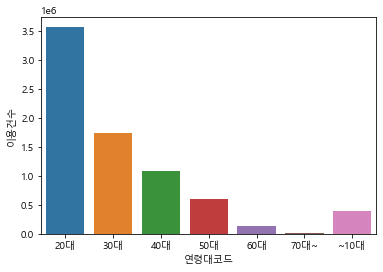

In [48]:
sns.barplot(data = df1, x = '연령대코드', y = '이용건수')

In [72]:
df2

,연령대코드,이용건수
0,20대,3559963
1,30대,1744751
2,40대,1085700
3,50대,602237
4,60대,152475
5,70대~,29707
6,~10대,409060


In [76]:
df2 = df1[['연령대코드','이용건수']].drop(5)

In [77]:
df2

,연령대코드,이용건수
0,20대,3559963
1,30대,1744751
2,40대,1085700
3,50대,602237
4,60대,152475
6,~10대,409060


fig1.set_size_inches(8,6)
ax1.pie(generation_summary['tot_suicide'],labels=generation_summary['generation'],autopct='%1.0f%%',shadow=True);
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('% Suicides across Generation')
plt.show();

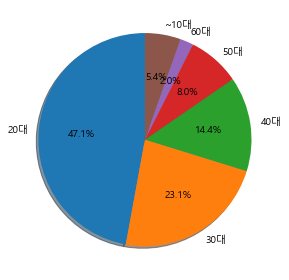

In [81]:
ax1 = plt.pie(df2.이용건수, labels=df2.연령대코드, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 10})
# Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

## 날씨데이터(시간별)

In [145]:
PATH =  P + '\\날씨데이터(시간별)\\'
weather = readcsv_(PATH)

(0) OBS_ASOS_TIM_20201116174637.csv
(1) OBS_ASOS_TIM_20201116174721.csv


폴더 내 csv / xlsx 파일 개수: 2개
총 데이터프레임 개수: 2개


In [146]:
weather[0].isna().sum()

지점              0
지점명             0
일시              0
기온(°C)          0
기온 QC플래그     8409
강수량(mm)      7937
강수량 QC플래그    7269
풍속(m/s)         7
풍속 QC플래그     8754
풍향(16방위)        7
풍향 QC플래그     8754
습도(%)           0
습도 QC플래그     8438
증기압(hPa)        0
일조(hr)       3972
일조 QC플래그     4790
일사(MJ/m2)    3974
적설(cm)       8678
dtype: int64

In [147]:
Weather = pd.concat([weather[0], weather[1]], axis=0)

In [148]:
weather[0] #전체로우 개수 8760, 기온qc플래그, 강수량 qc플래그, 풍향, qc플래그, 습도qc플래그, 증기압,일조,일사 드랍
#적설량 결측치 0
#강수량 결측치 0
#풍속 결측치0


,지점,지점명,일시,기온(°C),기온 QC플래그,강수량(mm),강수량 QC플래그,풍속(m/s),풍속 QC플래그,풍향(16방위),풍향 QC플래그,습도(%),습도 QC플래그,증기압(hPa),일조(hr),일조 QC플래그,일사(MJ/m2),적설(cm)
0,108,서울,2019-01-01 00:00,-5.5,0.0,NaN,NaN,1.0,0.0,290.0,0.0,54.0,0.0,2.2,NaN,9.0,NaN,NaN
1,108,서울,2019-01-01 01:00,-5.9,0.0,NaN,NaN,1.8,NaN,270.0,NaN,56.0,0.0,2.2,NaN,9.0,NaN,NaN
2,108,서울,2019-01-01 02:00,-6.5,0.0,NaN,NaN,1.2,NaN,290.0,NaN,60.0,0.0,2.3,NaN,9.0,NaN,NaN
3,108,서울,2019-01-01 03:00,-6.9,0.0,NaN,NaN,2.2,NaN,270.0,NaN,62.0,0.0,2.3,NaN,9.0,NaN,NaN
4,108,서울,2019-01-01 04:00,-7.2,0.0,NaN,NaN,1.2,NaN,270.0,NaN,57.0,0.0,2.0,NaN,9.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,108,서울,2019-12-31 19:00,-6.9,NaN,NaN,9.0,1.7,NaN,290.0,NaN,38.0,NaN,1.4,NaN,9.0,NaN,NaN
8756,108,서울,2019-12-31 20:00,-7.0,NaN,NaN,9.0,2.9,NaN,290.0,NaN,41.0,NaN,1.5,NaN,9.0,NaN,NaN
8757,108,서울,2019-12-31 21:00,-7.4,NaN,NaN,9.0,0.8,NaN,20.0,NaN,43.0,NaN,1.5,NaN,9.0,NaN,NaN
8758,108,서울,2019-12-31 22:00,-8.2,NaN,NaN,9.0,0.0,NaN,0.0,NaN,42.0,NaN,1.4,NaN,9.0,NaN,NaN


In [149]:
Weather.drop(['기온 QC플래그','강수량 QC플래그','풍향 QC플래그','풍향(16방위)','풍속 QC플래그','습도 QC플래그', '증기압(hPa)','일조 QC플래그',\
                 '일사(MJ/m2)','일조(hr)'], axis=1, inplace=True)

In [150]:
Weather.isna().sum()

지점             0
지점명            0
일시             0
기온(°C)         1
강수량(mm)    12928
풍속(m/s)        7
습도(%)          0
적설(cm)     14455
dtype: int64

In [151]:
Weather = Weather.fillna(0)
#강수량 적설 결측치 채우기

#### 일자/시간 나누기

In [152]:
Weather['날짜'] = Weather['일시'].apply(lambda x: x.split(' ')[0])
Weather['시간'] = Weather['일시'].apply(lambda x: x.split(' ')[1])

Weather.drop('일시', axis = 1, inplace = True)

In [153]:
Weather

,지점,지점명,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),날짜,시간
0,108,서울,-5.5,0.0,1.0,54.0,0.0,2019-01-01,00:00
1,108,서울,-5.9,0.0,1.8,56.0,0.0,2019-01-01,01:00
2,108,서울,-6.5,0.0,1.2,60.0,0.0,2019-01-01,02:00
3,108,서울,-6.9,0.0,2.2,62.0,0.0,2019-01-01,03:00
4,108,서울,-7.2,0.0,1.2,57.0,0.0,2019-01-01,04:00
...,...,...,...,...,...,...,...,...,...
5851,108,서울,28.0,0.0,3.5,73.0,0.0,2020-08-31,19:00
5852,108,서울,27.6,0.0,2.5,73.0,0.0,2020-08-31,20:00
5853,108,서울,27.1,0.0,2.4,74.0,0.0,2020-08-31,21:00
5854,108,서울,26.8,0.0,2.3,76.0,0.0,2020-08-31,22:00


#### 구마다의 날씨를 찾아야 함

## 대여소별_이용정보(월별)

In [154]:
PATH =  P + '\\대여소별_이용정보(월별)\\'
monthly_node = readcsv_(PATH)

(0) 공공자전거 대여소별 대여 정보 201906_201911 .csv
(1) 공공자전거 대여소별 대여 정보_201912_202005.csv
(2) 공공자전거 대여소별 대여 정보_202006.csv
(3) 공공자전거 대여소별 반납 정보 201906_201911 .csv
(4) 공공자전거 대여소별 반납 정보_201912_202005.csv
(5) 공공자전거 대여소별 반납 정보_202006.csv


폴더 내 csv / xlsx 파일 개수: 6개
총 데이터프레임 개수: 6개


In [155]:
for i in range(6):
    print(monthly_node[i].columns)

Index(['대여소 그룹', '대여소 명', '대여 일자 / 월', '대여 건수'], dtype='object')
Index(['대여소 그룹', '대여소 명', '대여 일자 / 월', '대여 건수'], dtype='object')
Index(['대여소 그룹', '대여소 명', '대여 일자 / 월', '대여 건수'], dtype='object')
Index(['대여소 그룹', '대여소 명', '반납 일자 / 월', '반납 건수', 'Unnamed: 4', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7'],
      dtype='object')
Index(['대여소 그룹', '대여소 명', '반납 일자 / 월', '반납 건수'], dtype='object')
Index(['대여소 그룹', '대여소 명', '반납 일자 / 월', '반납 건수'], dtype='object')


In [156]:
monthly_node[3].drop(['Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7'], axis=1, inplace=True)

In [157]:
#반납
Monthly_node_rent = pd.concat([monthly_node[0],monthly_node[1],monthly_node[2]], axis=0)
Monthly_node_rent

,대여소 그룹,대여소 명,대여 일자 / 월,대여 건수
0,강남구,2301. 현대고등학교 건너편,201906,3909
1,강남구,2302. 교보타워 버스정류장(신논현역 3번출구 후면),201906,2432
2,강남구,2303. 논현역 7번출구,201906,1567
3,강남구,2304. 신영 ROYAL PALACE 앞,201906,559
4,강남구,2305. MCM 본사 직영점 앞,201906,730
...,...,...,...,...
2057,중랑구,1473.중랑역 1번 출구(중화문화복지센터),202006,85
2058,중랑구,1477.면목삼익아파트 앞,202006,85
2059,중랑구,1478.홈플러스 상봉점 앞,202006,322
2060,중랑구,1479.면목 홈플러스 2,202006,150


In [158]:
#대여
Monthly_node_return = pd.concat([monthly_node[3],monthly_node[4],monthly_node[5]], axis=0)
Monthly_node_return

,대여소 그룹,대여소 명,반납 일자 / 월,반납 건수
0,강남구,2301. 현대고등학교 건너편,201906,4072
1,강남구,2302. 교보타워 버스정류장(신논현역 3번출구 후면),201906,2382
2,강남구,2303. 논현역 7번출구,201906,1402
3,강남구,2304. 신영 ROYAL PALACE 앞,201906,207
4,강남구,2305. MCM 본사 직영점 앞,201906,905
...,...,...,...,...
2057,중랑구,1473.중랑역 1번 출구(중화문화복지센터),202006,83
2058,중랑구,1477.면목삼익아파트 앞,202006,82
2059,중랑구,1478.홈플러스 상봉점 앞,202006,329
2060,중랑구,1479.면목 홈플러스 2,202006,166


In [159]:
Monthly_node_return['반납 일자 / 월'] = Monthly_node_return['반납 일자 / 월'].apply(lambda x : str(x)[:4] + '-'+ str(x)[4:])

In [160]:
Monthly_node_rent['대여 일자 / 월'] = Monthly_node_rent['대여 일자 / 월'].apply(lambda x : str(x)[:4] + '-'+ str(x)[4:])

In [161]:
Monthly_node_return.head()

,대여소 그룹,대여소 명,반납 일자 / 월,반납 건수
0,강남구,2301. 현대고등학교 건너편,2019-06,4072
1,강남구,2302. 교보타워 버스정류장(신논현역 3번출구 후면),2019-06,2382
2,강남구,2303. 논현역 7번출구,2019-06,1402
3,강남구,2304. 신영 ROYAL PALACE 앞,2019-06,207
4,강남구,2305. MCM 본사 직영점 앞,2019-06,905


In [162]:
Monthly_node_rent.head()

,대여소 그룹,대여소 명,대여 일자 / 월,대여 건수
0,강남구,2301. 현대고등학교 건너편,2019-06,3909
1,강남구,2302. 교보타워 버스정류장(신논현역 3번출구 후면),2019-06,2432
2,강남구,2303. 논현역 7번출구,2019-06,1567
3,강남구,2304. 신영 ROYAL PALACE 앞,2019-06,559
4,강남구,2305. MCM 본사 직영점 앞,2019-06,730


## 대여이력 디테일
- concat 하기

In [163]:
PATH =  P + '\\대여이력\\'
history = readcsv_(PATH)

(0) 공공자전거 대여이력 정보_201912.csv
(1) 공공자전거 대여이력 정보_2020.01.csv


C:\Users\justi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (4,6) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(2) 공공자전거 대여이력 정보_2020.02.csv
(3) 공공자전거 대여이력 정보_2020.03.csv
(4) 공공자전거 대여이력 정보_2020.04.csv
(5) 공공자전거 대여이력 정보_2020.05.csv
(6) 공공자전거 대여이력 정보_202006.csv
(7) 서울특별시 공공자전거 대여정보_201901.csv
(8) 서울특별시 공공자전거 대여정보_201902.csv
(9) 서울특별시 공공자전거 대여정보_201903.csv
(10) 서울특별시 공공자전거 대여정보_201904.csv
(11) 서울특별시 공공자전거 대여정보_201905.csv
(12) 서울특별시 공공자전거 대여정보_201906_1.csv
(13) 서울특별시 공공자전거 대여정보_201906_2.csv
(14) 서울특별시 공공자전거 대여정보_201906_3.csv
(15) 서울특별시 공공자전거 대여정보_201907_1.csv
(16) 서울특별시 공공자전거 대여정보_201907_2.csv
(17) 서울특별시 공공자전거 대여정보_201907_3.csv
(18) 서울특별시 공공자전거 대여정보_201908_1.csv
(19) 서울특별시 공공자전거 대여정보_201908_2.csv
(20) 서울특별시 공공자전거 대여정보_201908_3.csv
(21) 서울특별시 공공자전거 대여정보_201909_1.csv
(22) 서울특별시 공공자전거 대여정보_201909_2.csv
(23) 서울특별시 공공자전거 대여정보_201909_3.csv
(24) 서울특별시 공공자전거 대여정보_201910_1.csv
(25) 서울특별시 공공자전거 대여정보_201910_2.csv
(26) 서울특별시 공공자전거 대여정보_201910_3.csv
(27) 서울특별시 공공자전거 대여정보_201911_1.csv
(28) 서울특별시 공공자전거 대여정보_201911_2.csv


폴더 내 csv / xlsx 파일 개수: 29개
총 데이터프레임 개수: 29개


In [164]:
# [실패] history[10] = pd.read_csv(PATH  + '서울특별시 공공자전거 대여정보_201904.csv', index_col = cols, encoding = 'cp949')
# 없어진 columns 열 추가
a = {'자전거번호':'SPB-00352', "대여일시":'2019-04-01 00:00:07', '대여 대여소번호':'00364', '대여 대여소명':'창신역 1번출구 앞',\
                '대여거치대':8,'반납일시':'2019-04-01 00:04:36','반납대여소번호':'00361','반납대여소명':'동묘앞역 1번출구 뒤',\
                                "반납거치대":4,'이용시간':4.1, '이용거리':740.00}
cols = ['자전거번호', '대여일시', '대여 대여소번호', '대여 대여소명', '대여거치대', '반납일시', '반납대여소번호',
       '반납대여소명', '반납거치대', '이용시간', '이용거리']
history[10].columns = cols

history[10] = history[10].append(a, ignore_index=True).sort_values(by='대여일시').reset_index(drop=True)

b = {'자전거번호':'SPB-01857','대여일시':'2019-05-01 00:01:07','대여 대여소번호':'01908','대여 대여소명':'해원리바파크 육교 밑',\
'대여거치대':'3','반납일시':'2019-05-01 00:03:52','반납대여소번호':'01957','반납대여소명':'구일고등학교 정문','반납거치대':'6',\
'이용시간':'2','이용거리':'480.00'}
cols = ['자전거번호', '대여일시', '대여 대여소번호', '대여 대여소명', '대여거치대', '반납일시', '반납대여소번호',
       '반납대여소명', '반납거치대', '이용시간', '이용거리']
history[11].columns = cols

history[11] = history[11].append(a, ignore_index=True).sort_values(by='대여일시').reset_index(drop=True)

In [165]:
for i in notebook.tqdm(range(0,29)):
    print(i)
    history[i]['연'] = history[i]['대여일시'].apply(lambda x: str(x)[0:4])
    history[i]['월'] = history[i]['대여일시'].apply(lambda x: str(x)[5:7])
    history[i]['일'] = history[i]['대여일시'].apply(lambda x: str(x)[8:11])
    history[i]['시간'] = history[i]['대여일시'].apply(lambda x: str(x)[12:])
# for i in range(4,6):
#     history[i]['연'] = history[i]['반납 일자 / 월'].apply(lambda x: str(x)[0:4])
#     history[i]['월'] = history[i]['반납 일자 / 월'].apply(lambda x: str(x)[4:6])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28



In [166]:
history[11].isna().sum()

자전거번호       0
대여일시        0
대여 대여소번호    0
대여 대여소명     0
대여거치대       0
반납일시        0
반납대여소번호     0
반납대여소명      0
반납거치대       0
이용시간        0
이용거리        0
연           0
월           0
일           0
시간          0
dtype: int64

In [167]:
history[0].head(1)

,자전거번호,대여일시,대여 대여소번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간,이용거리,연,월,일,시간
0,SPB-07756,2019-12-01 00:00:09,512,뚝섬역 1번 출구 옆,6,2019-12-01 00:03:14,512,뚝섬역 1번 출구 옆,6,2,0.0,2019,12,01,0:00:09


In [168]:
history[1].head(1)

,자전거번호,대여일시,대여 대여소번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간,이용거리,연,월,일,시간
0,SPB-04061,2020-01-01 00:01:04,429,송도병원,2,2020-01-01 00:04:21,00372,약수역 3번출구 뒤,8,2.0,0.0,2020,01,01,0:01:04


In [169]:
history[7].shape

(476758, 15)

In [170]:
history[18].shape

(800000, 15)

#### 컬럼명 및 데이터형식 맞춰주기

In [171]:
for s in range(len(history[i].columns)):
    for i in range(len(history)):
#     print(i)
        print(f'{history[i].columns[s]}: {history[i].iloc[1,s]}')
    print('\n')

자전거번호: SPB-02716
자전거번호: SPB-06686
자전거번호: SPB-21546
자전거번호: SPB-15556
자전거번호: SPB-19055
자전거번호: SPB-13960
자전거번호: SPB-30703
자전거번호: SPB-17170
자전거번호: SPB-15190
자전거번호: SPB-18088
자전거번호: SPB-06746
자전거번호: SPB-03644
자전거번호: SPB-07446
자전거번호: SPB-06551
자전거번호: SPB-09319
자전거번호: SPB-22363
자전거번호: SPB-19381
자전거번호: SPB-02224
자전거번호: SPB-17426
자전거번호: SPB-24934
자전거번호: SPB-08790
자전거번호: SPB-20126
자전거번호: SPB-16915
자전거번호: SPB-14405
자전거번호: SPB-17653
자전거번호: SPB-08690
자전거번호: SPB-08834
자전거번호: SPB-16216
자전거번호: SPB-23502


대여일시: 2019-12-01 00:01:51
대여일시: 2020-01-01 00:02:53
대여일시: 2020-01-31 22:05:17
대여일시: 2020-02-29 23:46:45
대여일시: 2020-03-31 23:54
대여일시: 2020-04-30 23:36
대여일시: 2020-06-01 00:00:46
대여일시: 2019-01-01 00:03:09
대여일시: 2019-02-01 00:00:52
대여일시: 2019-03-01 00:00:34
대여일시: 2019-04-01 00:00:13
대여일시: 2019-05-01 00:00:00
대여일시: 2019-06-03 08:33:22
대여일시: 2019-06-01 21:28:21
대여일시: 2019-06-23 20:44:41
대여일시: 2019-07-03 08:35:06
대여일시: 2019-07-23 10:25:56
대여일시: 2019-07-24 22:23:43
대여일시: 2019-08-05 13:37:38
대여일시: 2019-08-11 

In [172]:
for i in range(len(history)):
    #     print(f'{i}')
    history[i].rename(columns={
        '대여소번호': '대여 대여소번호',
        '대여대여소명': '대여 대여소명',
        '거치대순번': '대여 거치대순번,',
        '대여거치대': '대여 거치대순번,',
        '대여소번호.1': '반납 대여소번호',
        '반납대여소번호': '반납 대여소번호',
        '반납대여소명': '반납 대여소명',
        '반납거치대': '반납 거치대순번',
        '반납거치대순번': '반납 거치대순번'
    },
        inplace=True)

#### concat 하기

In [173]:
a = [history[i] for i in range(len(history))]
len(a)
#최종합치기 
History = pd.concat(a, axis=0)

#### 시간 길이 맞춰주기

In [ ]:
History['대여시각'] = History['시간'].apply(lambda x: (x.split(':')[0] + ':' + x.split(':')[1]))

In [174]:
History

,자전거번호,대여일시,대여 대여소번호,대여 대여소명,"대여 거치대순번,",반납일시,반납 대여소번호,반납 대여소명,반납 거치대순번,이용시간,이용거리,연,월,일,시간
0,SPB-07756,2019-12-01 00:00:09,512,뚝섬역 1번 출구 옆,6,2019-12-01 00:03:14,512,뚝섬역 1번 출구 옆,6,2.0,0.0,2019,12,01,0:00:09
1,SPB-02716,2019-12-01 00:01:51,1151,마곡역1번출구,18,2019-12-01 00:03:41,1168,마곡엠밸리10단지 앞,10,1.0,380.0,2019,12,01,0:01:51
2,SPB-14606,2019-12-01 00:00:05,1244,문정 법조단지8,7,2019-12-01 00:04:52,2615,테라타워2,15,4.0,940.0,2019,12,01,0:00:05
3,SPB-16682,2019-12-01 00:01:24,908,구산역 4번출구,4,2019-12-01 00:04:57,906,연신내역 5번출구150M 아래,6,3.0,560.0,2019,12,01,0:01:24
4,SPB-23119,2019-12-01 00:00:07,2616,거여동 사거리,8,2019-12-01 00:05:02,1227,거여역 8번출구 뒤,3,4.0,570.0,2019,12,01,0:00:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678825,SPB-07983,2019-11-26 08:27:07,2183,동방1교,2,2019-11-26 09:31:27,99999,영남단말기정비,5,59.0,8520.0,2019,11,26,8:27:07
678826,SPB-24906,2019-11-27 08:26:19,2141,미림여고입구 교차로,2,2019-11-27 09:26:19,99999,영남단말기정비,5,59.0,8680.0,2019,11,27,8:26:19
678827,SPB-17861,2019-11-28 08:11:43,2183,동방1교,4,2019-11-28 08:54:39,99999,영남단말기정비,5,40.0,10570.0,2019,11,28,8:11:43
678828,SPB-17173,2019-11-29 08:12:31,2183,동방1교,1,2019-11-29 09:17:29,99999,영남단말기정비,5,64.0,10560.0,2019,11,29,8:12:31


## 초중고대 위치
- 컬럼명이 없다? what? 엑셀 다시 봐야할듯
- 0번째는 연도, 학교명(영문), 우편번호, 전화번호, 팩스번호, 홈페이지 삭제
- 3번쨰 df는 필요 없는게 아닌가?
- concat 하기, 위도 경도 추가하기

In [12]:
PATH =  P + '\\초중고대 위치\\'
school_loc = readcsv_(PATH)

(0) 1. 유·초·중등교육기관 주소록(201904기준).xlsx
(1) 2. 고등교육기관 주소록(201904기준).xlsx
(2) 전국초중등학교위치표준데이터.csv


폴더 내 csv / xlsx 파일 개수: 3개
총 데이터프레임 개수: 3개


In [13]:
Ele_middle_high = school_loc[0].drop([
    '학제', '연도', '고등학교유형', '우편번호', '팩스번호','홈페이지', '교육지원청','본분교','남여공학','연락처'], axis = 1)
Ele_middle_high.columns = ['학교종류', '시도','행정구','학교명','학교상태','설립','도로명주소']
Ele_middle_high = Ele_middle_high[Ele_middle_high['시도'] == '서울']

In [14]:
Ele_middle_high.head(3) # 위경도 

,학교종류,시도,행정구,학교명,학교상태,설립,도로명주소
0,유치원,서울,종로구,린덴바움유치원,기존(원)교,사립,서울특별시 종로구 통일로12길 51 . 린덴바움유치원 (무악동)
1,유치원,서울,종로구,배화여자대학교 부속 배화유치원,기존(원)교,사립,서울특별시 종로구 필운대로1길 34 (필운동)
2,유치원,서울,종로구,봄샘유치원,기존(원)교,사립,서울특별시 종로구 율곡로 264 (종로6가)


In [15]:
Univercity = school_loc[1].drop(['연도','학교명(영문)','우편번호','전화번호','팩스번호', '본분교', '홈페이지'], axis = 1)
Univercity.columns = ['학교종류', '시도','학교명','학교상태','설립','도로명주소']
Univercity = Univercity[Univercity['시도'] == '서울']

In [16]:
Univercity.head(3) # 행정구 추가할 것

,학교종류,시도,학교명,학교상태,설립,도로명주소
0,전문대학(4년제),서울,서울여자간호대학교,기존,사립,"서울특별시 서대문구 간호대로 38 (홍제동, 서울여자간호대학)"
4,전문대학(3년제),서울,동양미래대학교,기존,사립,"서울특별시 구로구 경인로 445 (고척동, 동양미래대학교)"
5,전문대학(3년제),서울,명지전문대학,기존,사립,"서울특별시 서대문구 가좌로 134 (홍은동, 명지전문대학)"


#### 대학 행정구 추가하기

In [17]:
Univercity['행정구'] = Univercity['도로명주소'].apply(lambda x: x.split(' ')[1])

#### 초중고 + 대학 concat하기

In [18]:
School_loc = pd.concat([Ele_middle_high, Univercity], axis = 0)

In [19]:
School_loc.reset_index(inplace = True)

In [20]:
School_loc

,index,학교종류,시도,행정구,학교명,학교상태,설립,도로명주소
0,0,유치원,서울,종로구,린덴바움유치원,기존(원)교,사립,서울특별시 종로구 통일로12길 51 . 린덴바움유치원 (무악동)
1,1,유치원,서울,종로구,배화여자대학교 부속 배화유치원,기존(원)교,사립,서울특별시 종로구 필운대로1길 34 (필운동)
2,2,유치원,서울,종로구,봄샘유치원,기존(원)교,사립,서울특별시 종로구 율곡로 264 (종로6가)
3,3,유치원,서울,종로구,상명사대부속유치원,기존(원)교,사립,서울특별시 종로구 홍지문2길 1 (홍지동)
4,4,유치원,서울,종로구,서울명신초등학교병설유치원,기존(원)교,공립,서울특별시 종로구 낙산길 250 (창신동. 서울명신초등학교)
...,...,...,...,...,...,...,...,...
2318,418,전공대학,서울,서초구,백석예술대학교,기존,사립,"서울특별시 서초구 방배로9길 23 (방배동, 백석예술대학교)"
2319,419,전공대학,서울,중구,정화예술대학교,기존,사립,"서울특별시 중구 퇴계로16길 21 (남산동1가, 정화예술대학교명동캠퍼스본관)"
2320,420,전공대학,서울,중구,정화예술대학교,기존,사립,"서울특별시 중구 퇴계로8길 73 (회현동1가, 정화예술대학교남산캠퍼스)"
2321,421,기능대학,서울,강서구,한국폴리텍대학 서울강서캠퍼스,기존,사립,"서울특별시 강서구 우장산로10길 112 (화곡동, 한국폴리텍대학서울강서캠퍼스)"


#### 위경도 추가하기(에러 고칠 것)

In [21]:
get_longlat('서울특별시 종로구 필운대로1길 34 (필운동)')

('126.968373106', '37.578079043')

In [22]:
School_loc['위도'] = 0
School_loc['경도'] = 0

In [23]:
for i in notebook.tqdm(School_loc.index):
    try:
        print(i, School_loc.loc[i, '도로명주소'])
        School_loc.loc[i, '위도'] = get_longlat(School_loc.loc[i, '도로명주소'])[1]
        School_loc.loc[i, '경도'] = get_longlat(School_loc.loc[i, '도로명주소'])[0]
    except Exception as ex:
        print(f'**Error: index {i}: {ex}**')
        pass
print('completed')

0 서울특별시 종로구 통일로12길 51 . 린덴바움유치원 (무악동)
1 서울특별시 종로구 필운대로1길 34 (필운동)
2 서울특별시 종로구 율곡로 264 (종로6가)
3 서울특별시 종로구 홍지문2길 1 (홍지동)
4 서울특별시 종로구 낙산길 250 (창신동. 서울명신초등학교)
5 서울특별시 종로구 북촌로4길 7 (가회동.서울재동초등학교)
6 서울특별시 종로구 지봉로 73 . 서울창신초등학교병설유치원 (창신동. 창신초등학교)
7 서울특별시 종로구 자하문로 105 (청운동) 병설유치원
8 서울특별시 종로구 혜화로 32 (혜화동. 혜화초등학교)
9 서울특별시 종로구 자하문로 310 (홍지동)
10 서울특별시 종로구 사직로8길 9 (필운동. 세종로천주교회)
11 서울특별시 종로구 자하문로 69 (옥인동)
12 서울특별시 종로구 삼일대로 460 (운니동)
13 서울특별시 종로구 동망산길 62 (숭인동)
14 서울특별시 종로구 평창길 317 (평창동)
15 서울특별시 종로구 혜화로6길 80 (혜화동)
16 서울특별시 종로구 창경궁로 296 (혜화동)
17 서울특별시 중구 청파로 447-1 (중림동)
18 서울특별시 중구 동호로20길 24 . 3층 (신당동)
19 서울특별시 중구 소파로2길 7 (예장동)
20 서울특별시 중구 다산로 269 (신당동)
21 서울특별시 중구 덕수궁길 140 (정동)
22 서울특별시 중구 청구로17길 40 . 서울장충유치원 (신당동. 장충초등학교)
23 서울특별시 중구 퇴계로 50길 13 (장충동2가)
24 서울특별시 중구 다산로 32 수암유치원 (신당동. 남산타운)
25 서울특별시 중구 소파로2길 10 (예장동. 숭의여자대학교)
26 서울특별시 중구 동호로10길 27 (신당동. 신일교회)
27 서울특별시 중구 동호로10길 30 (신당동. 약수하이츠)
28 서울특별시 중구 수표로 33 (저동1가. 영락교회)
29 서울특별시 중구 퇴계로6길 36 . 교육관 (남창동. 일신교회)
30 서울특별시 중구 퇴계로88다길 5 (신당동. 한일교회 선교사회관

221 서울특별시 성북구 성북로4길 52-1 (돈암동)
222 서울특별시 성북구 보문사길 18 (보문동3가)
223 서울특별시 성북구 돌곶이로 64 (석관동)
224 서울특별시 성북구 종암로24가길 53 (종암동.종암에스케이아파트101동)
225 서울특별시 성북구 성북로4길 52 (돈암동.한진아파트)
226 서울특별시 성북구 화랑로13길 17 (하월곡동.진각종(진각종))
227 서울특별시 성북구 길음로13길 29 (길음동)
228 서울특별시 성북구 서경로 166 . 한가람유치원 (정릉동)
229 서울특별시 성북구 월계로 124 (장위동)
230 서울특별시 성북구 서경로2길 16 (정릉동)
231 서울특별시 성북구 동소문로34길 24 . 희망찬유치원 (돈암동)
232 서울특별시 강북구 노해로21길 12 (수유동. 경은유치원)
233 서울특별시 강북구 한천로123길 9 (번동)
234 서울특별시 강북구 오패산로30길 75 (미아동)
235 서울특별시 강북구 한천로115길 15 . 꿈동산유치원
236 서울특별시 강북구 오패산로 130 (미아동)
237 서울특별시 강북구 도봉로97길 45 (수유동)
238 서울특별시 강북구 솔샘로 195 (미아동)
239 서울특별시 강북구 오현로 204 (번동)
240 서울특별시 강북구 삼양로20길 29 (미아동. 송천초등학교)
241 서울특별시 강북구 삼양로74길 39 (수유동.수유초등학교)
242 서울특별시 강북구 솔매로50가길 25 (미아동)
243 서울특별시 강북구 삼각산로 143-1 (수유동)
244 서울특별시 강북구 삼각산로 161 (수유동. 인보성체수도회)
245 서울특별시 강북구 솔샘로 159 (미아동.벽산라이브파크)
246 서울특별시 강북구 인수봉로72길 4 . 신극동유치원 (수유동. 극동아파트)
247 서울특별시 강북구 도봉로 88 (미아동)
248 서울특별시 강북구 삼양로49길 18 예원유치원 (미아동)
249 서울특별시 강북구 수유로4길 58 (수유동)
250 서울특별시 강북구 인수봉로 297 (우이동)
251 

453 서울특별시 양천구 남부순환로30길 17 (신월동. 광영고등학교.광영여자고등학교.광영유치원)
454 서울특별시 양천구 오목로4길 8 (신월동)
455 서울특별시 양천구 목동서로 280 (신정동. 목동신시가지아파트8단지)
456 서울특별시 양천구 오목로13길 31 . 대한유치원 (신월동)
457 서울특별시 양천구 목동중앙북로7길 22 (목동)
458 서울특별시 양천구 목동동로12길 60 . 단지내 등대유치원 (신정동. 목동현대아파트)
459 서울특별시 양천구 목동중앙북로8길 46 (목동)
460 서울특별시 양천구 목동중앙북로24길 19-8 . 레인보우유치원 (목동)
461 서울특별시 양천구 월정로9길 23-4 . 다솜유치원 (신월동)
462 서울특별시 양천구 오목로42길 13 . 목동유치원 (신정동)
463 서울특별시 양천구 목동동로 50 (신정동. 목동신시가지아파트12단지)
464 서울특별시 양천구 목동로 212 (목동. 목동신시가지아파트7단지)
465 서울특별시 양천구 곰달래로9길 12 (신월동)
466 서울특별시 양천구 지양로5길 2 (신월동)
467 서울특별시 양천구 목동서로 340 . 새서울유치원 (신정동. 목동신시가지아파트9단지)
468 서울특별시 양천구 신월로 99 (신월동.신월시영아파트)
469 서울특별시 양천구 월정로 280 . 서울강신초등학교병설유치원 (신월동.서울강신초등학교)
470 서울특별시 양천구 신월로 97 (신월동)
471 서울특별시 양천구 안양천로 1009 . 서울경인유치원 (목동. 서울경인초등학교)
472 서울특별시 양천구 목동로8길 19 서울서정초등학교 (목동)
473 서울특별시 양천구 신정로 292 (신정동.서울신기초등학교)
474 서울특별시 양천구 남부순환로58길 32 (신월동.서울신원초등학교)
475 서울특별시 양천구 신정이펜2로 30 (신정동)
476 서울특별시 양천구 목동로11길 30 (신정동.서울양목초등학교병설유치원)
477 서울특별시 양천구 목동중앙북로16길 57 (목동.서울양화초등학교)
478 서울특별시 양천구

666 서울특별시 동작구 사당로23길 57-14 서울남성초등학교 (사당동)
667 서울특별시 동작구 장승배기로 160 (노량진동)
668 서울특별시 동작구 신대방2길 14 (신대방동.서울문창초등학교)
669 서울특별시 동작구 노량진로26길 16-40 (본동)
670 서울특별시 동작구 만양로3길 48 . 서울상도유치원 (노량진동. 유치원)
671 서울특별시 동작구 사당로 146 (사당동)
672 서울특별시 동작구 서달로 115 (흑석동.은로초등학교)
673 서울특별시 동작구 솔밭로 47 (사당동) 서울행림초등학교병설유치원
674 서울특별시 동작구 장승배기로5길 16 (상도동.성모유치원)
675 서울특별시 동작구 현충로 119 .소망유치원 (흑석동. 명수대현대아파트)
676 서울특별시 동작구 사당로2다길 95 . 송림유치원 (사당동)
677 서울특별시 동작구 성대로21길 15 (상도동)
678 서울특별시 동작구 만양로8길 50 . 시현유치원 (노량진동. 우성아파트)
679 서울특별시 동작구 시흥대로 644-1 (신대방동)
680 서울특별시 동작구 여의대방로44길 49 . 열림유치원 (대방동)
681 서울특별시 동작구 현충로 153 (흑석동.한강현대아파트)
682 서울특별시 동작구 여의대방로 28 . 요요유치원 (신대방동. 현대아파트)
683 서울특별시 동작구 성대로6가길 29 (상도동. 애광유치원)
684 서울특별시 동작구 흑석로 47 (흑석동.중앙대학교사범대학유치원)
685 서울특별시 동작구 사당로 143 총신대학교 부속 유치원 (사당동)
686 서울특별시 동작구 동작대로41길 7 (동작동)
687 서울특별시 동작구 양녕로23길 25 (상도동)
688 서울특별시 동작구 만양로 26 (상도동)
689 서울특별시 관악구 조원로 114 (신림동.건영유치원)
690 서울특별시 관악구 난곡로 42 (신림동. 파크프라자)
691 서울특별시 관악구 봉천로 33길 57 . 두산아파트 단지내
692 서울특별시 관악구 행운1길 96 (봉천동)
693 서울특별시 관악구 광신길 15

885 서울특별시 강동구 올림픽로104길 36 (암사동.한강현대아파트)
886 서울특별시 강동구 천중로35길 37-1 (천호동)
887 서울특별시 종로구 홍지문2길 1 . 상명사대부속초등학교 (홍지동.상명초등학교)
888 서울특별시 종로구 삼일대로 446 (경운동)
889 서울특별시 종로구 대학로 64 서울대학교사범대학부설초등학교 (이화동)
890 서울특별시 종로구 통일로12길 23 (무악동)
891 서울특별시 종로구 사직로9길 19 . 서울매동초등학교 (필운동)
892 서울특별시 종로구 낙산길 250 (창신동)
893 서울특별시 종로구 세검정로9길 1 (신영동.서울세검정초등학교)
894 서울특별시 종로구 북촌로4길 7 . 서울재동초등학교 (가회동)
895 서울특별시 종로구 지봉로 73 . 서울창신초등학교 (창신동)
896 서울특별시 종로구 자하문로 105 . 청운초등학교 (청운동)
897 서울특별시 종로구 혜화로 32 . 서울혜화초등학교 (혜화동)
898 서울특별시 종로구 대학로 12 . 서울효제초등학교 (효제동)
899 서울특별시 종로구 삼일대로 460 . (운니동. 운현초등학교 (운니동)
900 서울특별시 중구 매봉18길 109 동산초등학교 (신당동)
901 서울특별시 중구 소파로2길 7 (예장동)
902 서울특별시 중구 다산로 269 . 서울광희초등학교 (신당동)
903 서울특별시 중구 퇴계로22길 17 . 서울남산초등학교 (남산동2가)
904 서울특별시 중구 덕수궁길 140 서울덕수초등학교 (정동)
905 서울특별시 중구 손기정로 73 (만리동2가)
906 서울특별시 중구 난계로 141 (신당동)
907 서울특별시 중구 청구로17길 40 . 서울장충초등학교 (신당동)
908 서울특별시 중구 다산로 170 (신당동.청구초등학교)
909 서울특별시 중구 퇴계로50길 13 (장충동2가. 충무초등학교)
910 서울특별시 중구 청구로6길 11 (신당동.흥인초등학교)
911 서울특별시 중구 소파로2길 10 (예장동.숭의여자대학)
912 서울특별시 용산구 효창원로

1099 서울특별시 노원구 동일로 1745 (상계동.서울수락초등학교)
1100 서울특별시 노원구 중계로12길 9 (중계동.수암초등학교)
1101 서울특별시 노원구 초안산로 29 (월계동.신계초등학교)
1102 서울특별시 노원구 상계로 267 . 신상계초등학교 (상계동)
1103 서울특별시 노원구 월계로55길 48 (월계동)
1104 서울특별시 노원구 공릉로58길 36 . 서울연촌초등학교 (하계동)
1105 서울특별시 노원구 한글비석로52길 59 (상계동.온곡초등학교)
1106 서울특별시 노원구 한글비석로1길 81-11 (중계동.용동초등학교)
1107 서울특별시 노원구 섬밭로 144 . 용원초등학교 (공릉동. 서울용원초등학교)
1108 서울특별시 노원구 덕릉로76길 18 (중계동.원광초등학교)
1109 서울특별시 노원구 월계로45가길 10 (월계동.월계초등학교)
1110 서울특별시 노원구 중계로 239 (중계동)
1111 서울특별시 노원구 한글비석로19길 39 . 서울중계초등학교 (중계동)
1112 서울특별시 노원구 섬밭로 316 (중계동)
1113 서울특별시 노원구 섬밭로 241 . 서울중평초등학교 (하계동)
1114 서울특별시 노원구 섬밭로 181 . 서울중현초등학교 (하계동.중현초등학교)
1115 서울특별시 노원구 공릉로 431 (중계동. 청계초등학교)
1116 서울특별시 노원구 화랑로51나길 31 . 서울태랑초등학교 (공릉동)
1117 서울특별시 노원구 노원로1길 36 (공릉동. 태릉초등학교)
1118 서울특별시 노원구 마들로 45 . 서울한천초등학교 (월계동)
1119 서울특별시 노원구 한글비석로 506 . (상계동.청원초/중/고등학교) (상계동)
1120 서울특별시 노원구 화랑로 815 . 태강삼육초등학교 (공릉동)
1121 서울특별시 노원구 화랑로 621 . 서울여자대학교 (공릉동)
1122 서울특별시 은평구 연서로29길 31 . 갈현초등학교 (갈현동)
1123 서울 은평구 서오릉로15길 16 (구산동.서울구산초등학교)
1124 서울특별시 은평구 갈

1312 서울특별시 영등포구 도림로53길 32-9 서울도신초등학교(대림동. 도신초등학교)
1313 서울특별시 영등포구 문래로 104 (문래동3가. 문래초등학교)
1314 서울특별시 영등포구 선유로43가길 14 (양평동3가. 서울선유초등학교)
1315 서울특별시 영등포구 대림로8길 25 (대림동)
1316 서울특별시 영등포구 도신로4길 32 (대림동.신영초등학교)
1317 서울특별시 영등포구 여의대방로 439 . 서울여의도초등학교 (여의도동)
1318 서울특별시 영등포구 국회대로53길 20 . (당산동. 영동초등학교) (당산동)
1319 서울특별시 영등포구 경인로 756 (문래동1가)
1320 서울특별시 영등포구 시흥대로173길 14 . 서울영림초등학교 (대림동)
1321 서울특별시 영등포구 문래로 56 . 서울영문초등학교 (문래동6가)
1322 서울특별시 영등포구 도신로60길 23 (신길동)
1323 서울특별시 영등포구 도영로 22길 31 (도림동)
1324 서울특별시 영등포구 양산로 185 . 서울영중초등학교 (영등포동7가)
1325 서울특별시 영등포구 신길로 190 (신길동.우신초등학교)
1326 서울특별시 영등포구 여의나루로2길 14 (여의도동)
1327 서울특별시 동작구 강남초등길 15 (상도1동. 강남초등학교)
1328 서울특별시 동작구 동작대로13길 22 (사당동)
1329 서울특별시 동작구 사당로23길 57-14 (사당동. 서울남성초등학교)
1330 서울특별시 동작구 장승배기로 160 (노량진동)
1331 서울특별시 동작구 대방동1길 22 (대방동)
1332 서울특별시 동작구 동작대로29길 214 . 서울동작초등학교 (사당동)
1333 서울특별시 동작구 신대방2길 14 (신대방동.서울문창초등학교)
1334 서울특별시 동작구 여의대방로16길 30 . 서울보라매초등학교 (신대방동)
1335 서울특별시 동작구 노량진로26길 16-40 . 서울본동초등학교 (본동)
1336 서울특별시 동작구 사당로23나길 27 . 서울삼일초등학교 (사당동)
1337 서울특

1525 서울특별시 성동구 행당로 120 (행당동)
1526 서울특별시 성동구 서울숲길 18 (성수동1가. 성수중.고등학교)
1527 서울특별시 성동구 성덕정9가길 13 (성수동2가. 성원중학교)
1528 서울특별시 성동구 한림말길 11 . 옥정중학교 (옥수동)
1529 서울특별시 성동구 마조로 42 (사근동.한양사대부속중·고등학교)
1530 서울특별시 성동구 왕십리로 189 (행당동.행당중학교)
1531 서울특별시 광진구 자양로 145-1 건국대학교사범대학부속중학교
1532 서울특별시 광진구 아차산로70길 17-62 . 광남중학교 (광장동)
1533 서울특별시 광진구 자양로3길 7 (자양동)
1534 서울특별시 광진구 광장로1길 1 . 광장중학교 (광장동)
1535 서울특별시 광진구 뚝섬로64길 45 (자양동.광진중학교)
1536 서울특별시 광진구 광나루로30길 80 (화양동)
1537 서울특별시 광진구 용마산로22길 26 . 대원국제중학교 (중곡동)
1538 서울특별시 광진구 광나루로36길 47 (구의동.동국대학교사범대학부속여자중고등학교)
1539 서울특별시 광진구 자양강변길 73 . 신양중학교 (자양동)
1540 서울특별시 광진구 워커힐로 32 . 양진중학교
1541 서울특별시 광진구 용마산로22길 76 (중곡동.용곡중학교)
1542 서울특별시 광진구 뚝섬로41길 33 (자양동.서울자양중학교)
1543 서울특별시 동대문구 경희대로 26 (회기동)
1544 서울특별시 동대문구 경희대로 26 . 경희중학교 (회기동)
1545 서울특별시 동대문구 안암로 6 (신설동) 대광중학교
1546 서울특별시 동대문구 장안벚꽃로 201 (장안동)
1547 서울특별시 동대문구 사가정로 59 . 동대문중학교 (전농동)
1548 서울특별시 동대문구 왕산로23길 55 (제기동)
1549 서울특별시 동대문구 천호대로47길 34 (답십리동. 숭인중학교)
1550 서울특별시 동대문구 답십리로72길 158 . 장평중학교 (장안동)
1551 서울특별시 동대문구 사가정로13길 71 (전농동

1749 서울특별시 금천구 한내로 69-44 (독산동.안천중학교)
1750 서울특별시 금천구 독산로50길 60 한울중학교
1751 서울특별시 영등포구 당산로41길 12 (당산동5가.당산서중학교)
1752 서울특별시 영등포구 버드나루로 160 (당산동)
1753 서울특별시 영등포구 시흥대로185길 6 (대림동.대림중학교)
1754 서울특별시 영등포구 도림로80가길 14 (신길동. 대영중학교)
1755 서울특별시 영등포구 선유서로13길 6 (문래동6가.문래중학교)
1756 서울특별시 영등포구 선유로 213 (양평동3가)
1757 서울특별시 영등포구 당산로 56 (문래동3가. 양화중학교)
1758 서울특별시 영등포구 국제금융로7길 46 . 여의도중학교 (여의도동)
1759 서울특별시 영등포구 대림로31나길 17 . 영남중학교 (대림동)
1760 서울특별시 영등포구 영등포로62길 31 (영등포동.영원중학교)
1761 서울특별시 영등포구 여의동로3길 3 (여의도동. 윤중중학교)
1762 서울특별시 동작구 대방동15길 29 (대방동. 강남중학교)
1763 서울특별시 동작구 상도로13라길 22 .강현중학교(상도동)
1764 서울특별시 동작구 양녕로20길 20 . 국사봉중학교 (상도동)
1765 서울특별시 동작구 남부순환로269길 166 (사당동.남성중학교)
1766 서울특별시 동작구 여의대방로10길 24 (신대방동. 대방중학교)
1767 서울특별시 동작구 흑석로9길 94 . 동양중학교  (흑석동)
1768 서울특별시 동작구 동작대로39가길 83 (동작동)
1769 서울특별시 동작구 여의대방로22나길 40 (신대방동)
1770 서울특별시 동작구 사당로9가길 58 . 사당중학교 (사당동)
1771 서울특별시 동작구 사당로2가길 72 . 상도중학교 (사당동)
1772 서울특별시 동작구 사당로2길 2-19 (상도동)
1773 서울특별시 동작구 대방동길 74 (대방동)
1774 서울특별시 동작구 여의대방로36길 79 . 숭의여자중학교 (대방동)
1775 서울특별시 동작구 등용로8길

1966 서울특별시 성북구 성북로14가길 23 (성북동.홍익대학교부속중고등학교)
1967 서울특별시 강북구 인수봉로 39 . 미양고등학교 (미아동)
1968 서울특별시 강북구 삼양로19길 40 (미아동.삼각산고등학교)
1969 서울특별시 강북구 도봉로29길 52 (미아동. 성암국제무역고등학교)
1970 서울특별시 강북구 솔매로49길 20 (미아동.신일중고등학교)
1971 서울특별시 강북구 도봉로13가길 19 (미아동.학교법인영훈학원)
1972 서울특별시 강북구 월계로 61 . 창문여자고등학교 (미아동)
1973 서울특별시 강북구 인수봉로 127 (수유동. 혜화여자고등학교)
1974 서울특별시 도봉구 마들로 849 . 누원고등학교 (도봉동)
1975 서울특별시 도봉구 도봉산길 27 (도봉동.도봉고등학교)
1976 서울특별시 도봉구 마들로 598 . 서울문화고등학교 (방학동)
1977 서울특별시 도봉구 덕릉로66길 22 (창동)
1978 서울특별시 도봉구 시루봉로 53 .  선덕고등학교 (쌍문동)
1979 서울특별시 도봉구 시루봉로 53 세그루패션디자인고등학교(쌍문동)
1980 서울특별시 도봉구 노해로69길 150 (창동)
1981 서울특별시 도봉구 노해로49길 69 (쌍문동)
1982 서울특별시 도봉구 노해로62길 7 (창동. 창동고등학교)
1983 서울특별시 도봉구 우이천로 432 (쌍문동.효문중 고등학교)
1984 서울특별시 노원구 공릉로 264 (하계동)
1985 서울특별시 노원구 광운로1길 24 (월계동.광운중학교/전자공업고등학교)
1986 서울특별시 노원구 노원로 586 (상계동)
1987 서울특별시 노원구 공릉로62가길 47 . 대진고등학교 (하계동)
1988 서울특별시 노원구 공릉로 438 . 대진여자고등학교 (중계동)
1989 서울특별시 노원구 공릉로 257 . 동산정보산업고등학교 (공릉동)
1990 서울특별시 노원구 덕릉로82길 54 (중계동)
1991 서울특별시 노원구 중계로 155 (중계동)
1992 서울특별시 노원구 노해로 432 (상계동.

2182 서울특별시 송파구 송파대로38길 8 (송파동) 잠실여자고등학교
2183 서울특별시 송파구 백제고분로 21 (잠실동)
2184 서울특별시 송파구 올림픽로4길 16 . 정신여자고등학교 (잠실동)
2185 서울특별시 송파구 양재대로 1240 . 창덕여자고등학교 (방이동)
2186 서울특별시 강동구 구천면로 572 (상일동)
2187 서울특별시 강동구 아리수로98길 40 (강일동)
2188 서울특별시 강동구 동남로 968 광문고등학교 (고덕동)
2189 서울특별시 강동구 강동대로 305 (둔촌동)
2190 서울특별시 강동구 명일로 140 (둔촌동.둔촌고등학교)
2191 서울특별시 강동구 명일로 350 (명일동.명일여자고등학교)
2192 서울특별시 강동구 고덕로 227 (고덕동.배재중 고등학교)
2193 서울특별시 강동구 천호대로219길 61 . 상일미디어고등학교 (상일동)
2194 서울특별시 강동구 천호대로219길 61 . 상일여자고등학교 (상일동)
2195 서울특별시 강동구 동남로 964 . 서울컨벤션고등학교 (고덕동)
2196 서울특별시 강동구 고덕로25길 17 . 선사고등학교 (암사동)
2197 서울특별시 강동구 구천면로 396 (천호동. 성덕고등학교)
2198 서울특별시 강동구 동남로 832 (상일동. 한영고등학교)
2199 서울특별시 강동구 동남로 832 (상일동)
2200 서울특별시 종로구 삼일대로 454 (경운동)
2201 서울특별시 종로구 필운대로 103 (신교동. 국립서울농학교)
2202 서울특별시 종로구 필운대로 97 (신교동)
2203 서울특별시 종로구 사직로7길 17 . 수도사랑의학교 (사직동)
2204 서울특별시 광진구 강변역로 18 (구의동. 서울광진학교)
2205 서울특별시 성북구 성북로31길 5-15 . 서울다원학교 (성북동)
2206 서울특별시 강북구 솔매로52길 31 . 서울애화학교 (미아동. 서울애화학교)
2207 서울특별시 강북구 인수봉로 119-20 . 서울정인학교 (수유동)
2208 서울특별시 강북구 삼양로63길 33 

In [24]:
# School_loc['위도'] = School_loc.apply(lambda x: get_longlat(x['도로명주소'])[1], axis = 0)
# School_loc['경도'] = School_loc.apply(lambda x: get_longlat(x['도로명주소'])[0], axis = 0)

In [25]:
# School_loc['위도'] = School_loc['도로명주소'].apply(lambda x: get_longlat(x)[1])
# School_loc['경도'] = School_loc['도로명주소'].apply(lambda x: get_longlat(x)[0])

In [ ]:
School_loc.head(3)

## 버스정류장
- 표준id ars-id (보류)
- 비고 삭제
- '데이터생성일자' 컬럼 생성 후 구분해주기

In [ ]:
PATH =  P + '\\버스정류장\\'
bus = readcsv_(PATH)

In [ ]:
bus[0]['데이터생성일자'] = '20190710'

In [191]:
bus[1]['데이터생성일자'] = '20200306'

In [192]:
# 2020 년에 추가된 것을 0번에 붙이기

In [193]:
Bus_2020 = pd.concat([bus[0], bus[1].drop('비고', axis = 1)])

In [194]:
Bus_2020

,표준ID,정류장명,ARS-ID,X좌표,Y좌표,데이터생성일자
0,100000001,종로2가사거리,1001,126.987750,37.569765,20190710
1,100000002,창경궁.서울대학교병원,1002,126.996566,37.579183,20190710
2,100000003,명륜3가.성대입구,1003,126.998340,37.582671,20190710
3,100000004,종로2가.삼일교,1004,126.987613,37.568579,20190710
4,100000005,혜화동로터리.여운형활동터,1005,127.001744,37.586243,20190710
...,...,...,...,...,...,...
11275,124000334,우성아파트,25995,127.139339,37.550386,20200306
11276,124000333,우성아파트,25996,127.140046,37.550643,20200306
11277,124000332,조일약국,25997,127.123596,37.533630,20200306
11278,124000331,성내시장,25998,127.125497,37.536155,20200306


In [195]:
Bus_2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22459 entries, 0 to 11279
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   표준ID     22459 non-null  int64  
 1   정류장명     22459 non-null  object 
 2   ARS-ID   22459 non-null  int64  
 3   X좌표      22459 non-null  float64
 4   Y좌표      22459 non-null  float64
 5   데이터생성일자  22459 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 1.2+ MB


## 서울시 우리마을가게 상권분석서비스(상권-추정유동인구)

In [196]:
PATH =  P + '\\서울시 우리마을가게 상권분석서비스(상권-추정유동인구)\\'
commercial_census = readcsv_(PATH)

(0) 서울시 우리마을가게 상권분석서비스(상권-추정유동인구).csv


폴더 내 csv / xlsx 파일 개수: 1개
총 데이터프레임 개수: 1개


In [197]:
Commercial_census = commercial_census[0]

## 최종 데이터 프레임

### 자전거 보관소

In [198]:
Bike_lock.to_csv('Bike_lock.csv', index = False)

### 가로수길

In [199]:
Garosugil.to_csv('Garosugil.csv', index = False)

### 공원

In [200]:
Citypark.to_csv('Citypark.csv', index = False)

### 전통시장

In [201]:
Market.to_csv('Market.csv', index = False)

### 지하철

In [25]:
Subway.to_csv('Subway.csv', index = False, encoding = 'utf-8')

### 구별 인구 통계

In [203]:
Cencus2019.to_csv('Cencus2019.csv', index = False)

### 시간별 유동인구

In [204]:
Floating_list.to_csv('Floating_list.csv', index = False)

### 자전거 고장

In [205]:
Bike_break.to_csv('Bike_break.csv', index = False)

### 월별 자전거 이용 정보 

In [206]:
Monthly_bike_usage.to_csv('Monthly_bike_usage.csv', index = False)

### 시간별 자전거 이용 정보

In [207]:
Hour_bike_usage.to_csv('Hour_bike_usage.csv', index = False)

### 시간별 날씨

In [208]:
Weather.to_csv('Weather.csv', index = False)

### 월별 대여소 이용 정보

In [209]:
Monthly_node_rent.to_csv('Monthly_node_rent.csv', index = False)

In [210]:
Monthly_node_return.to_csv('Monthly_node_return.csv', index = False)

###  대여 이력 디테일

In [212]:
History.to_csv('history.csv', index = False)

### 학교 위치

In [26]:
School_loc.to_csv('School_loc.csv', index = False)

### 버스 정류장 위치

In [ ]:
Bus_2020.to_csv('Bus_2020.csv', index = False)

### 상권분석

In [ ]:
Commercial_census